# Package initiation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import shutil
import random
import pprint
import itertools
import functools
import collections

import pysam
import pyranges as pr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import scipy.stats

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev/')

In [2]:
from handygenome import common
from handygenome.common import ChromDict, Interval
from handygenome.variant.vcfspec import Vcfspec
from handygenome.sv.breakends import Breakends
from handygenome.variant.variantplus import VariantPlus, VariantPlusList
from handygenome.variant.vcfplus import VcfPlus
from handygenome.igvhandle import IGVHandle

from handygenome.variant import filter as libvpfilter
# from handygenome.vcfeditor.initvcf import create_header

In [3]:
FASTA_PATH_HG19 = "/home/users/data/01_reference/human_g1k_v37/human_g1k_v37.fasta"
FASTA_PATH_HG38 = "/home/users/data/01_reference/human_g1k_v38/Homo_sapiens_assembly38.fasta"

FASTA_HG19 = pysam.FastaFile(FASTA_PATH_HG19)
FASTA_HG38 = pysam.FastaFile(FASTA_PATH_HG38)
CHROMDICT_HG19 = ChromDict(fasta_path=FASTA_PATH_HG19)
CHROMDICT_HG38 = ChromDict(fasta_path=FASTA_PATH_HG38)

In [4]:
igv = IGVHandle(60387)

# Basic setups

In [5]:
SAMPLEIDS = [
    '14', '6', '87', 'F13', 'F2', 'F33', 'F37', 'FF1', 'FF104', 'FF115', 'FF13', 'FF18', 'FF20', 'FF21', 'FF23', 'FF24', 'FF27', 
    'FF3', 'FF31', 'FF34', 'FF37', 'FF39', 'FF4', 'FF43', 'FF53', 'FF56', 'FF57', 'FF58', 'FF6', 'FF62', 'FF67', 'FF71', 'FF76', 
    'FF77', 'FF78', 'FF79', 'FF80', 'FF85', 
    #'IO04',  # swapped sample
    'IO05', 'IO06', 'IO07', 'IO08', 'IO09', 'IO12', 'IO13', 'IO15', 'IO16', 'IO17', 
    'IO18', 'IO22', 'IO23', 'IO24', 'IO25', 'SC126', 'SC134', 'SC31', 'SC81', 'SC88', 'SC97', 'SC98', 
]
SAMPLEIDS_LU = [f'LU-{x}' for x in SAMPLEIDS]
SAMPLEIDS_LU_PANEL = [f'{x}_panel' for x in SAMPLEIDS_LU]
SAMPLEIDS_LU_TUMOR = [f'{x}_tumor' for x in SAMPLEIDS_LU]

BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/'
PANEL_REGION_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged.bed'
PANEL_REGION_EXONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_exon_Regions_tracknamechanged.bed'
PANEL_REGION_INTRONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_intron_Regions_tracknamechanged.bed'
WGS_TMB_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/wgs_TMB_previously_found_210312.txt'

ONCOKB_TOKEN = '864a64ee-cfa0-4b99-aa25-305fb4bcda39'

In [6]:
BAM_PATHS = {'normal': dict(), 'tumor': dict(), 'panel': dict()}
for top, dirs, files in os.walk(BAM_TOPDIR):
    for f in files:
        for sampleid in SAMPLEIDS_LU:
            for sampletype in ('tumor', 'normal', 'panel'):
                if f == f'{sampleid}.{sampletype}.bam':
                    BAM_PATHS[sampletype][sampleid] = os.path.join(top, f)

In [7]:
BAMS = {sampletype: {sampleid: pysam.AlignmentFile(bampath) 
                     for sampleid, bampath in bampathdic.items()}
        for sampletype, bampathdic in BAM_PATHS.items()}

In [8]:
def load_bams(sampleid):
    igv.load([BAM_PATHS['normal'][sampleid], BAM_PATHS['tumor'][sampleid], BAM_PATHS['panel'][sampleid]])

In [9]:
def show_vp_igv(vp, sampleid):
    igv.cmd('new')
    igv.load([PANEL_REGION_PATH, PANEL_REGION_EXONS_PATH, PANEL_REGION_INTRONS_PATH])
    load_bams(sampleid)

    igv.goto([vp.vcfspec], width=200)
    igv.cmd('viewaspairs')
    igv.cmd('sort base')

# Missed driver detection test

In [10]:
# PREVIOUS_WGS_REANNOT_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results/feature_annot_220810'
PREVIOUS_WGS_REANNOT_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results/reannot_220914/'
PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV = dict()
PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL = dict()

for fname in os.listdir(PREVIOUS_WGS_REANNOT_TOPDIR):
    if fname.endswith('.annot.readstats.oncokb.vcf.gz'):
        sampleid = fname.split('.')[0]
        if 'snv' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)
        elif 'indel' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)

In [11]:
PREVIOUS_WGS_REANNOT_VCF_SNV = dict()
PREVIOUS_WGS_REANNOT_VCF_INDEL = dict()

for key, val in PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV.items():
    print('snv', key)
    PREVIOUS_WGS_REANNOT_VCF_SNV[key] = VariantPlusList.from_vcf(val, logging_lineno=None, init_all_attrs=False)

for key, val in PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL.items():
    print('indel', key)
    PREVIOUS_WGS_REANNOT_VCF_INDEL[key] = VariantPlusList.from_vcf(val, logging_lineno=None, init_all_attrs=False)

snv LU-FF115
snv LU-FF79
snv LU-FF76
snv LU-IO25
snv LU-FF3
snv LU-IO16
snv LU-SC97
snv LU-IO24
snv LU-FF85
snv LU-FF58
snv LU-SC31
snv LU-FF27
snv LU-F33
snv LU-87
snv LU-SC88
snv LU-FF78
snv LU-FF24
snv LU-FF37
snv LU-IO06
snv LU-IO12
snv LU-FF71
snv LU-SC98
snv LU-FF4
snv LU-FF6
snv LU-IO17
snv LU-FF13
snv LU-F37
snv LU-SC134
snv LU-FF67
snv LU-IO18
snv LU-14
snv LU-F13
snv LU-FF23
snv LU-SC126
snv LU-FF62
snv LU-FF1
snv LU-FF43
snv LU-FF80
snv LU-IO08
snv LU-IO09
snv LU-FF20
snv LU-FF56
snv LU-FF77
snv LU-FF39
snv LU-IO13
snv LU-IO15
snv LU-FF18
snv LU-IO22
snv LU-6
snv LU-F2
snv LU-IO07
snv LU-FF21
snv LU-IO23
snv LU-FF57
snv LU-IO05
snv LU-FF34
snv LU-FF53
snv LU-SC81
snv LU-FF31
snv LU-FF104
indel LU-FF78
indel LU-F33
indel LU-FF85
indel LU-F13
indel LU-IO24
indel LU-6
indel LU-FF43
indel LU-FF18
indel LU-IO23
indel LU-FF56
indel LU-FF1
indel LU-F37
indel LU-IO15
indel LU-FF37
indel LU-FF27
indel LU-FF80
indel LU-IO25
indel LU-IO22
indel LU-IO18
indel LU-FF62
indel LU-87
indel L

### Running realignment

In [40]:
import handygenome.align.realign as librealign
import handygenome.align.realign.base as librealign_base
import handygenome.align.realign.msrpileup as librealign_msrpileup
import handygenome.align.realign.msrpileup_series as librealign_msrpileup_series
import handygenome.align.realign.rpileup as librealign_rpileup
import handygenome.align.realign.rpileup_series as librealign_rpileup_series

In [461]:
sid = 'LU-14'
tbam = BAMS['tumor']['LU-14']
nbam = BAMS['normal']['LU-14']
# bam_dict = {'normal': nbam, 'tumor': tbam}

bam_dict = {
    # 'normal': nbam, 
    'tumor': tbam,
}

In [465]:
RESULTDIR = '/home/users/pjh/tmp/indel_realigner_driver_discovery/'
if not os.path.exists(RESULTDIR):
    os.mkdir(RESULTDIR)

##### indel

In [ ]:
for sid in SAMPLEIDS_LU:
    print(sid)
    
    tbam = BAMS['tumor'][sid]
    # nbam = BAMS['normal']['LU-14']
    # bam_dict = {'normal': nbam, 'tumor': tbam}

    bam_dict = {
        # 'normal': nbam, 
        'tumor': tbam,
    }

    old_vplist = VariantPlusList(refver='hg19')
    new_vplist = VariantPlusList(refver='hg19')

    for idx, old_vp in enumerate(PREVIOUS_WGS_REANNOT_VCF_INDEL[sid]):
        if idx % 1000 == 0:
        # if True:
            print(idx)
            print(old_vp)
            
        # if idx == 3:
        #     break

        try:
            msrpileup_ser = librealign_msrpileup_series.MultisampleRealignerPileupSeries(
                chrom=old_vp.chrom, 
                start0=old_vp.start0, 
                end0=old_vp.end0,
                bam_dict=bam_dict, 
                refver='hg19',
                inactive_padding=20,
                verbose=False,
                # start0_limit=146_993_520,
                # end0_limit=146_993_620,
                # max_pileup_width=100,

                active_threshold_vaf=0.05,
            )
            vcfspec = msrpileup_ser.get_result_vcfspecs(portion_cutoff=0.04, verbose=False)[0]
        except:
            continue
        
        if vcfspec is None:
            continue

        new_vp = VariantPlus.from_vcfspec(vcfspec)

        old_vplist.append(old_vp)
        new_vplist.append(new_vp)


    old_vplist_path = os.path.join(RESULTDIR, f'{sid}.old.vcf.gz')
    new_vplist_path = os.path.join(RESULTDIR, f'{sid}.new.vcf.gz')

    old_vplist.write(old_vplist_path)
    new_vplist.write(new_vplist_path)
    
    # break

LU-14
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=16,286,498, ref='CCTTGAGGGGACGCCCCGAGCA', alts=('C',)), alteration=(alt_index 0: ))>
LU-6
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=2,704,855, ref='TGTGTGTGTGTTATGTACATGTTGTGTGTTGTATGTGTGTTATGTACATGTGTGTTGTGTGTG', alts=('T',)), alteration=(alt_index 0: ))>
LU-87
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,536,641, ref='G', alts=('GC',)), alteration=(alt_index 0: ))>
LU-F13
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=24,091,225, ref='C', alts=('CTCCT',)), alteration=(alt_index 0: ))>
LU-F2
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=21,175,539, ref='CA', alts=('C',)), alteration=(alt_index 0: ))>
LU-F33
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=613,366, ref='AC', alts=('A',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00721:31:HFWNGDSXX:3:1321:31421:6183', flag=113, chrom='4', pos0=49135876))
('tumor', ReadUID(qname='A00721:31:HFWNGDSXX:3:1321:31421:6183', flag=113, chrom='4', pos0=49135876))
('tumor', Read

[KST 2023-06-14 09:01:05.298] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 09:01:06.787] VariantPlusList: Processing 1,000th line


LU-FF20
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=11,651,313, ref='CA', alts=('C',)), alteration=(alt_index 0: ))>
LU-FF21
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=2,240,958, ref='CT', alts=('C',)), alteration=(alt_index 0: ))>
LU-FF23
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=20,438,413, ref='C', alts=('CTTATTTTATTTTATT',)), alteration=(alt_index 0: ))>
LU-FF24
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=2,092,323, ref='GAGAA', alts=('G',)), alteration=(alt_index 0: ))>
LU-FF27
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=10,580,205, ref='C', alts=('CTTTTTTTTTTTTTTTTT',)), alteration=(alt_index 0: ))>
LU-FF3
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=4,948,882, ref='AAT', alts=('A',)), alteration=(alt_index 0: ))>
LU-FF31
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=40,251,527, ref='TCTAA', alts=('T',)), alteration=(alt_index 0: ))>
LU-FF34
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=9,725,933, ref='T', alts=('TC',)), alteration=(alt_index 0: ))>
('tumor', ReadUI

[KST 2023-06-14 09:45:07.364] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 09:45:07.475] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 09:45:07.587] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 09:45:07.701] VariantPlusList: Processing 4,000th line
[KST 2023-06-14 09:45:07.817] VariantPlusList: Processing 5,000th line
[KST 2023-06-14 09:45:07.936] VariantPlusList: Processing 6,000th line
[KST 2023-06-14 09:45:08.062] VariantPlusList: Processing 7,000th line
[KST 2023-06-14 09:45:08.748] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 09:45:08.754] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 09:45:08.760] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 09:45:08.765] VariantPlusList: Processing 4,000th line
[KST 2023-06-14 09:45:08.770] VariantPlusList: Processing 5,000th line
[KST 2023-06-14 09:45:08.776] VariantPlusList: Processing 6,000th line
[KST 2023-06-14 09:45:08.781] VariantPlusList: Processing 7,000th line


LU-FF56
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=6,567,550, ref='GC', alts=('G',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='20', pos=40,436,314, ref='C', alts=('CT',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 09:49:56.987] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 09:49:57.170] VariantPlusList: Processing 1,000th line


LU-FF57
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=36,069,645, ref='A', alts=('AG',)), alteration=(alt_index 0: ))>
LU-FF58
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=22,145,966, ref='C', alts=('CTTTATAAATTACCTTTATAAATTTATAAA',)), alteration=(alt_index 0: ))>
LU-FF6
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=3,111,271, ref='A', alts=('ACACGCCATCGTCTCCCCGCCA',)), alteration=(alt_index 0: ))>
LU-FF62
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=4,114,552, ref='TG', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=114,607,610, ref='C', alts=('CA',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='3', pos=172,358,924, ref='T', alts=('TA',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=79,410,737, ref='TC', alts=('T',)), alteration=(alt_index 0: ))>
4000
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=99,307,411, ref='G', alts=('GTGTA',)), alteration=(alt_index 0: ))>
5000
<VariantPlus(

[KST 2023-06-14 10:21:36.858] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 10:21:36.969] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 10:21:37.077] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 10:21:37.190] VariantPlusList: Processing 4,000th line
[KST 2023-06-14 10:21:37.298] VariantPlusList: Processing 5,000th line
[KST 2023-06-14 10:21:37.418] VariantPlusList: Processing 6,000th line
[KST 2023-06-14 10:21:37.530] VariantPlusList: Processing 7,000th line
[KST 2023-06-14 10:21:37.658] VariantPlusList: Processing 8,000th line
[KST 2023-06-14 10:21:38.445] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 10:21:38.450] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 10:21:38.456] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 10:21:38.462] VariantPlusList: Processing 4,000th line
[KST 2023-06-14 10:21:38.468] VariantPlusList: Processing 5,000th line
[KST 2023-06-14 10:21:38.474] VariantPlusList: Processing 6,000th line
[KST 2

LU-FF67
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=22,720,747, ref='A', alts=('AAAAGAAAGAAAGAAAGAAAGAAAG',)), alteration=(alt_index 0: ))>
LU-FF71
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=52,721,273, ref='A', alts=('AG',)), alteration=(alt_index 0: ))>
LU-FF76
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=5,559,554, ref='TGACA', alts=('T',)), alteration=(alt_index 0: ))>
LU-FF77
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=16,478,021, ref='A', alts=('AAG',)), alteration=(alt_index 0: ))>
LU-FF78
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=4,391,867, ref='GCAGCACGCACGTCACAACTGTAGCACACACACGTCACAACTA', alts=('G',)), alteration=(alt_index 0: ))>
LU-FF79
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=6,007,110, ref='TCACA', alts=('T',)), alteration=(alt_index 0: ))>
LU-FF80
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=750,683, ref='GGAGCTGAGGGAT', alts=('G',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=33,606,473, ref='AT', alts=('A',)), altera

[KST 2023-06-14 10:46:35.583] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 10:46:35.695] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 10:46:35.816] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 10:46:36.234] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 10:46:36.240] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 10:46:36.245] VariantPlusList: Processing 3,000th line


LU-FF85
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=4,448,896, ref='T', alts=('TG',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=41,930,241, ref='TG', alts=('T',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='21', pos=23,332,862, ref='A', alts=('AT',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 10:53:58.419] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 10:53:58.538] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 10:53:58.774] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 10:53:58.781] VariantPlusList: Processing 2,000th line


LU-IO05
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=14,467,903, ref='AG', alts=('A',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:2:1534:7627:20055', flag=163, chrom='8', pos0=55619431))
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:2:1534:7627:20055', flag=163, chrom='8', pos0=55619431))
1000
<VariantPlus(vcfspec=Vcfspec(chrom='14', pos=68,833,295, ref='AG', alts=('A',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 10:58:43.752] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 10:58:44.617] VariantPlusList: Processing 1,000th line


LU-IO06
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=2,295,790, ref='G', alts=('GC',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='11', pos=35,797,785, ref='G', alts=('GT',)), alteration=(alt_index 0: ))>
LU-IO07
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=3,468,488, ref='TGCC', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=140,760,755, ref='C', alts=('CA',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=161,541,599, ref='CT', alts=('C',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:2:2425:24551:2049', flag=83, chrom='6', pos0=88417319))
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:2:2425:24551:2049', flag=83, chrom='6', pos0=88417319))
3000
<VariantPlus(vcfspec=Vcfspec(chrom='6', pos=139,661,078, ref='G', alts=('GTT',)), alteration=(alt_index 0: ))>
4000
<VariantPlus(vcfspec=Vcfspec(chrom='9', pos=35,595,148, ref='GC', alts=('G',)), alteration=(al

[KST 2023-06-14 11:32:19.643] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 11:32:19.760] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 11:32:19.876] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 11:32:19.994] VariantPlusList: Processing 4,000th line
[KST 2023-06-14 11:32:20.113] VariantPlusList: Processing 5,000th line
[KST 2023-06-14 11:32:20.233] VariantPlusList: Processing 6,000th line
[KST 2023-06-14 11:32:21.800] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 11:32:21.805] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 11:32:21.811] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 11:32:21.817] VariantPlusList: Processing 4,000th line
[KST 2023-06-14 11:32:21.823] VariantPlusList: Processing 5,000th line
[KST 2023-06-14 11:32:21.829] VariantPlusList: Processing 6,000th line


LU-IO08
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=4,873,368, ref='A', alts=('AAC',)), alteration=(alt_index 0: ))>
LU-IO09
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=4,649,212, ref='GA', alts=('G',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=25,729,076, ref='C', alts=('CA',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:1:1254:32190:25958', flag=163, chrom='12', pos0=53383631))
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:1:1254:32190:25958', flag=163, chrom='12', pos0=53383631))
2000
<VariantPlus(vcfspec=Vcfspec(chrom='17', pos=15,174,665, ref='A', alts=('AT',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 11:42:48.743] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 11:42:48.864] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 11:42:49.110] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 11:42:49.115] VariantPlusList: Processing 2,000th line


LU-IO12
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=3,359,490, ref='GT', alts=('G',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='6', pos=145,642,585, ref='GC', alts=('G',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='13', pos=108,008,411, ref='TG', alts=('T',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 11:54:26.499] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 11:54:26.614] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 11:54:26.914] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 11:54:26.919] VariantPlusList: Processing 2,000th line


LU-IO13
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=5,681,063, ref='C', alts=('CCT',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:2:2159:18331:12633', flag=161, chrom='2', pos0=55933544))
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:2:2159:18331:12633', flag=161, chrom='2', pos0=55933544))
1000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=177,643,033, ref='T', alts=('TA',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:2:1234:20247:32174', flag=81, chrom='9', pos0=7680089))
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:2:1234:20247:32174', flag=81, chrom='9', pos0=7680089))
('tumor', ReadUID(qname='A00721:31:HFWNGDSXX:3:1356:25654:2425', flag=145, chrom='13', pos0=75215005))
('tumor', ReadUID(qname='A00721:31:HFWNGDSXX:3:1356:25654:2425', flag=145, chrom='13', pos0=75215005))
2000
<VariantPlus(vcfspec=Vcfspec(chrom='13', pos=102,958,118, ref='AT', alts=('A',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 12:06:56.664] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 12:06:56.779] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 12:06:57.164] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 12:06:57.170] VariantPlusList: Processing 2,000th line


LU-IO15
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=23,497,588, ref='A', alts=('AAT',)), alteration=(alt_index 0: ))>
LU-IO16
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=11,212,736, ref='TG', alts=('T',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00125:179:HFVCKDSXX:1:1560:21052:6825', flag=99, chrom='16', pos0=927219))
('tumor', ReadUID(qname='A00125:179:HFVCKDSXX:1:1560:21052:6825', flag=99, chrom='16', pos0=927219))
1000
<VariantPlus(vcfspec=Vcfspec(chrom='16', pos=49,227,871, ref='GC', alts=('G',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 12:15:30.283] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 12:15:31.921] VariantPlusList: Processing 1,000th line


LU-IO17
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,197,386, ref='C', alts=('CACT',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=57,153,731, ref='GC', alts=('G',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='8', pos=79,975,245, ref='CT', alts=('C',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='15', pos=90,851,828, ref='T', alts=('TTGC',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 12:33:39.438] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 12:33:39.547] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 12:33:39.671] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 12:33:40.046] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 12:33:40.052] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 12:33:40.058] VariantPlusList: Processing 3,000th line


LU-IO18
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,621,746, ref='A', alts=('AAT',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='22', pos=50,538,952, ref='C', alts=('CT',)), alteration=(alt_index 0: ))>
LU-IO22
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=4,257,801, ref='TA', alts=('T',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00125:179:HFVCKDSXX:1:1506:12789:10363', flag=163, chrom='4', pos0=13234482))
('tumor', ReadUID(qname='A00125:179:HFVCKDSXX:1:1506:12789:10363', flag=163, chrom='4', pos0=13234482))
1000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=11,835,987, ref='C', alts=('CT',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00125:179:HFVCKDSXX:1:1126:30228:18490', flag=83, chrom='10', pos0=28123253))
('tumor', ReadUID(qname='A00125:179:HFVCKDSXX:1:1126:30228:18490', flag=83, chrom='10', pos0=28123253))
('tumor', ReadUID(qname='A00125:179:HFVCKDSXX:1:2266:3278:36918', flag=99, chrom='10', pos0=42356040))
('tumor', ReadU

[KST 2023-06-14 12:55:52.304] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 12:55:52.422] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 12:55:52.873] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 12:55:52.879] VariantPlusList: Processing 2,000th line


LU-IO23
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=5,138,427, ref='TG', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='14', pos=24,179,065, ref='C', alts=('CA',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 13:02:04.354] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 13:02:04.490] VariantPlusList: Processing 1,000th line


LU-IO24
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=2,170,120, ref='GGA', alts=('G',)), alteration=(alt_index 0: ))>
LU-IO25
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,518,309, ref='GCC', alts=('G',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=27,836,611, ref='TC', alts=('T',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 13:08:53.333] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 13:08:53.463] VariantPlusList: Processing 1,000th line


LU-SC126
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=5,197,846, ref='GT', alts=('G',)), alteration=(alt_index 0: ))>
LU-SC134
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=2,567,782, ref='C', alts=('CT',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00125:179:HFVCKDSXX:1:1172:16043:9298', flag=81, chrom='7', pos0=32619060))
('tumor', ReadUID(qname='A00125:179:HFVCKDSXX:2:2141:15374:3630', flag=113, chrom='7', pos0=32619031))
LU-SC31
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=5,055,995, ref='AAAC', alts=('A',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00721:31:HFWNGDSXX:1:2306:2926:16579', flag=83, chrom='1', pos0=145324008))
('tumor', ReadUID(qname='A00721:31:HFWNGDSXX:1:2306:2926:16579', flag=83, chrom='1', pos0=145324008))
LU-SC81
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=5,605,544, ref='T', alts=('TA',)), alteration=(alt_index 0: ))>


##### snv

In [ ]:
for sid in SAMPLEIDS_LU:
    print(sid)
    
    tbam = BAMS['tumor'][sid]
    # nbam = BAMS['normal']['LU-14']
    # bam_dict = {'normal': nbam, 'tumor': tbam}

    bam_dict = {
        # 'normal': nbam, 
        'tumor': tbam,
    }

    old_vplist = VariantPlusList(refver='hg19')
    new_vplist = VariantPlusList(refver='hg19')

    for idx, old_vp in enumerate(PREVIOUS_WGS_REANNOT_VCF_SNV[sid]):
        if idx % 1000 == 0:
        # if True:
            print(idx)
            print(old_vp)
            
        # if idx == 3:
        #     break

        try:
            msrpileup_ser = librealign_msrpileup_series.MultisampleRealignerPileupSeries(
                chrom=old_vp.chrom, 
                start0=old_vp.start0, 
                end0=old_vp.end0,
                bam_dict=bam_dict, 
                refver='hg19',
                inactive_padding=20,
                verbose=False,
                # start0_limit=146_993_520,
                # end0_limit=146_993_620,
                # max_pileup_width=100,

                active_threshold_vaf=0.05,
            )
            vcfspec = msrpileup_ser.get_result_vcfspecs(portion_cutoff=0.04, verbose=False)[0]
        except:
            continue
        
        if vcfspec is None:
            continue

        new_vp = VariantPlus.from_vcfspec(vcfspec)

        old_vplist.append(old_vp)
        new_vplist.append(new_vp)


    old_vplist_path = os.path.join(RESULTDIR, f'{sid}.snv.old.vcf.gz')
    new_vplist_path = os.path.join(RESULTDIR, f'{sid}.snv.new.vcf.gz')

    old_vplist.write(old_vplist_path)
    new_vplist.write(new_vplist_path)
    
    # break

LU-14
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=3,130,443, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=70,123,083, ref='T', alts=('C',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='X', pos=66,458,425, ref='G', alts=('A',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 20:53:19.945] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 20:53:20.073] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 20:53:20.282] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 20:53:20.287] VariantPlusList: Processing 2,000th line


LU-6
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,693,192, ref='A', alts=('G',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='8', pos=98,785,004, ref='G', alts=('C',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 20:58:39.168] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 20:58:39.400] VariantPlusList: Processing 1,000th line


LU-87
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=3,679,492, ref='A', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=9,044,077, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='11', pos=27,343,063, ref='T', alts=('G',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='X', pos=63,052,752, ref='A', alts=('C',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 21:06:21.168] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 21:06:21.287] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 21:06:21.418] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 21:06:21.680] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 21:06:21.685] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 21:06:21.689] VariantPlusList: Processing 3,000th line


LU-F13
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=840,715, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=25,418,658, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='9', pos=120,009,447, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='17', pos=74,579,050, ref='G', alts=('A',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 21:18:20.724] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 21:18:20.844] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 21:18:20.980] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 21:18:21.409] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 21:18:21.414] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 21:18:21.418] VariantPlusList: Processing 3,000th line


LU-F2
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,038,612, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='16', pos=7,126,621, ref='C', alts=('T',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 21:22:02.950] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 21:22:03.130] VariantPlusList: Processing 1,000th line


LU-F33
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=969,922, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=199,901,421, ref='A', alts=('G',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00721:31:HFWNGDSXX:4:2526:3125:10160', flag=163, chrom='3', pos0=25736340))
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:3:2233:14660:29450', flag=81, chrom='3', pos0=25736336))
2000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=35,412,795, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:3:2457:18728:6183', flag=83, chrom='6', pos0=167501358))
('tumor', ReadUID(qname='A00718:46:HFW5WDSXX:3:2457:18728:6183', flag=83, chrom='6', pos0=167501358))
3000
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=122,257,292, ref='G', alts=('C',)), alteration=(alt_index 0: ))>
4000
<VariantPlus(vcfspec=Vcfspec(chrom='11', pos=25,939,565, ref='A', alts=('G',)), alteration=(alt_index 0: ))>
5000
<VariantPlus(vcfsp

[KST 2023-06-14 21:40:30.826] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 21:40:30.936] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 21:40:31.064] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 21:40:31.183] VariantPlusList: Processing 4,000th line
[KST 2023-06-14 21:40:31.308] VariantPlusList: Processing 5,000th line
[KST 2023-06-14 21:40:32.324] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 21:40:32.329] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 21:40:32.334] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 21:40:32.338] VariantPlusList: Processing 4,000th line
[KST 2023-06-14 21:40:32.343] VariantPlusList: Processing 5,000th line


LU-F37
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=4,294,883, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=117,115,051, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='12', pos=122,080,108, ref='T', alts=('G',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 21:47:52.433] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 21:47:52.560] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 21:47:53.006] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 21:47:53.011] VariantPlusList: Processing 2,000th line


LU-FF1
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,343,632, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=215,451,255, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=84,757,670, ref='A', alts=('G',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=225,938,250, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
4000
<VariantPlus(vcfspec=Vcfspec(chrom='3', pos=165,173,931, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
5000
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=122,276,808, ref='T', alts=('G',)), alteration=(alt_index 0: ))>
6000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=16,407,560, ref='C', alts=('A',)), alteration=(alt_index 0: ))>
7000
<VariantPlus(vcfspec=Vcfspec(chrom='6', pos=25,650,984, ref='C', alts=('A',)), alteration=(alt_index 0: ))>
8000
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=20,125,855, ref='C', alts=('A',)), alter

[KST 2023-06-14 22:33:08.489] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 22:33:08.600] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 22:33:08.713] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 22:33:08.822] VariantPlusList: Processing 4,000th line
[KST 2023-06-14 22:33:08.929] VariantPlusList: Processing 5,000th line
[KST 2023-06-14 22:33:09.029] VariantPlusList: Processing 6,000th line
[KST 2023-06-14 22:33:09.135] VariantPlusList: Processing 7,000th line
[KST 2023-06-14 22:33:09.236] VariantPlusList: Processing 8,000th line
[KST 2023-06-14 22:33:09.347] VariantPlusList: Processing 9,000th line
[KST 2023-06-14 22:33:09.453] VariantPlusList: Processing 10,000th line
[KST 2023-06-14 22:33:09.569] VariantPlusList: Processing 11,000th line
[KST 2023-06-14 22:33:09.685] VariantPlusList: Processing 12,000th line
[KST 2023-06-14 22:33:09.788] VariantPlusList: Processing 13,000th line
[KST 2023-06-14 22:33:09.901] VariantPlusList: Processing 14,000th line
[

LU-FF104
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,195,716, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=131,888,638, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='13', pos=94,418,833, ref='G', alts=('C',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 22:41:16.075] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 22:41:16.197] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 22:41:16.568] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 22:41:16.572] VariantPlusList: Processing 2,000th line


LU-FF115
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,050,420, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='6', pos=95,917,707, ref='G', alts=('C',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='18', pos=23,946,661, ref='T', alts=('C',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 22:49:03.426] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 22:49:03.555] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 22:49:03.815] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 22:49:03.819] VariantPlusList: Processing 2,000th line


LU-FF13
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=2,275,139, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=16,227,517, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=44,117,642, ref='T', alts=('G',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='12', pos=59,756,460, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
('tumor', ReadUID(qname='ST-E00181:658:HT532CCXY:5:2124:31568:56247', flag=113, chrom='21', pos0=30213534))
('tumor', ReadUID(qname='ST-E00181:658:HT532CCXY:5:2124:31568:56247', flag=113, chrom='21', pos0=30213534))
4000
<VariantPlus(vcfspec=Vcfspec(chrom='22', pos=39,936,812, ref='G', alts=('A',)), alteration=(alt_index 0: ))>


[KST 2023-06-14 23:03:36.636] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 23:03:36.753] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 23:03:36.878] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 23:03:37.014] VariantPlusList: Processing 4,000th line
[KST 2023-06-14 23:03:37.422] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 23:03:37.426] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 23:03:37.431] VariantPlusList: Processing 3,000th line
[KST 2023-06-14 23:03:37.436] VariantPlusList: Processing 4,000th line


LU-FF18
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,062,214, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=107,680,669, ref='C', alts=('G',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=208,522,777, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=50,045,137, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
4000
<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=144,855,868, ref='C', alts=('A',)), alteration=(alt_index 0: ))>
5000
<VariantPlus(vcfspec=Vcfspec(chrom='3', pos=18,380,272, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
6000
<VariantPlus(vcfspec=Vcfspec(chrom='3', pos=134,841,809, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
7000
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=16,356,522, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
8000
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=73,060,703, ref='G', alts=('C',)), alte

[KST 2023-06-15 00:42:23.654] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 00:42:23.774] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 00:42:23.902] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 00:42:24.014] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 00:42:24.136] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 00:42:24.253] VariantPlusList: Processing 6,000th line
[KST 2023-06-15 00:42:24.377] VariantPlusList: Processing 7,000th line
[KST 2023-06-15 00:42:24.476] VariantPlusList: Processing 8,000th line
[KST 2023-06-15 00:42:24.580] VariantPlusList: Processing 9,000th line
[KST 2023-06-15 00:42:24.678] VariantPlusList: Processing 10,000th line
[KST 2023-06-15 00:42:24.804] VariantPlusList: Processing 11,000th line
[KST 2023-06-15 00:42:24.900] VariantPlusList: Processing 12,000th line
[KST 2023-06-15 00:42:25.021] VariantPlusList: Processing 13,000th line
[KST 2023-06-15 00:42:25.133] VariantPlusList: Processing 14,000th line
[

LU-FF20
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,660,704, ref='T', alts=('C',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='3', pos=4,100,632, ref='A', alts=('G',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=19,191,607, ref='T', alts=('G',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=56,777,055, ref='T', alts=('G',)), alteration=(alt_index 0: ))>
4000
<VariantPlus(vcfspec=Vcfspec(chrom='11', pos=55,647,128, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
5000
<VariantPlus(vcfspec=Vcfspec(chrom='15', pos=81,828,569, ref='G', alts=('C',)), alteration=(alt_index 0: ))>
6000
<VariantPlus(vcfspec=Vcfspec(chrom='21', pos=43,155,917, ref='T', alts=('G',)), alteration=(alt_index 0: ))>


[KST 2023-06-15 01:02:58.611] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 01:02:58.720] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 01:02:58.841] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 01:02:58.962] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 01:02:59.083] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 01:02:59.224] VariantPlusList: Processing 6,000th line
[KST 2023-06-15 01:02:59.987] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 01:02:59.992] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 01:02:59.998] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 01:03:00.003] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 01:03:00.008] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 01:03:00.014] VariantPlusList: Processing 6,000th line


LU-FF21
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,436,408, ref='T', alts=('C',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='3', pos=115,257,627, ref='G', alts=('C',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='6', pos=18,030,448, ref='C', alts=('G',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='9', pos=110,950,303, ref='C', alts=('A',)), alteration=(alt_index 0: ))>
4000
<VariantPlus(vcfspec=Vcfspec(chrom='15', pos=27,854,455, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
5000
<VariantPlus(vcfspec=Vcfspec(chrom='X', pos=72,201,138, ref='C', alts=('T',)), alteration=(alt_index 0: ))>


[KST 2023-06-15 01:22:47.619] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 01:22:47.738] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 01:22:47.869] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 01:22:47.991] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 01:22:48.133] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 01:22:48.573] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 01:22:48.578] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 01:22:48.583] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 01:22:48.588] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 01:22:48.593] VariantPlusList: Processing 5,000th line


LU-FF23
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=2,386,740, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=183,577,294, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='8', pos=109,895,796, ref='T', alts=('A',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='14', pos=87,186,143, ref='T', alts=('C',)), alteration=(alt_index 0: ))>
4000
<VariantPlus(vcfspec=Vcfspec(chrom='X', pos=135,377,426, ref='C', alts=('A',)), alteration=(alt_index 0: ))>


[KST 2023-06-15 01:36:03.275] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 01:36:03.395] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 01:36:03.522] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 01:36:03.647] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 01:36:04.025] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 01:36:04.031] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 01:36:04.037] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 01:36:04.042] VariantPlusList: Processing 4,000th line


LU-FF24
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=138,370, ref='A', alts=('T',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=240,966,283, ref='T', alts=('A',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=218,872,996, ref='G', alts=('C',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=42,099,513, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
4000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=45,643,813, ref='T', alts=('C',)), alteration=(alt_index 0: ))>
5000
<VariantPlus(vcfspec=Vcfspec(chrom='6', pos=164,770,269, ref='C', alts=('G',)), alteration=(alt_index 0: ))>
6000
<VariantPlus(vcfspec=Vcfspec(chrom='8', pos=82,693,847, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
7000
<VariantPlus(vcfspec=Vcfspec(chrom='11', pos=38,157,556, ref='T', alts=('C',)), alteration=(alt_index 0: ))>
8000
<VariantPlus(vcfspec=Vcfspec(chrom='13', pos=112,930,752, ref='C', alts=('G',)), alte

[KST 2023-06-15 02:14:45.446] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 02:14:45.559] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 02:14:45.680] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 02:14:45.781] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 02:14:45.898] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 02:14:46.016] VariantPlusList: Processing 6,000th line
[KST 2023-06-15 02:14:46.132] VariantPlusList: Processing 7,000th line
[KST 2023-06-15 02:14:46.257] VariantPlusList: Processing 8,000th line
[KST 2023-06-15 02:14:46.386] VariantPlusList: Processing 9,000th line
[KST 2023-06-15 02:14:46.520] VariantPlusList: Processing 10,000th line
[KST 2023-06-15 02:14:47.455] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 02:14:47.460] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 02:14:47.466] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 02:14:47.471] VariantPlusList: Processing 4,000th line
[KST 

LU-FF27
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=4,303,283, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
LU-FF3
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,368,562, ref='C', alts=('G',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=132,590,013, ref='G', alts=('C',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='13', pos=88,179,125, ref='C', alts=('T',)), alteration=(alt_index 0: ))>


[KST 2023-06-15 02:24:25.725] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 02:24:25.852] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 02:24:26.216] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 02:24:26.221] VariantPlusList: Processing 2,000th line


LU-FF31
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,347,073, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
LU-FF34
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=14,395,006, ref='A', alts=('G',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='18', pos=62,171,453, ref='C', alts=('G',)), alteration=(alt_index 0: ))>


[KST 2023-06-15 02:32:12.416] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 02:32:12.610] VariantPlusList: Processing 1,000th line


LU-FF37
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=2,795,302, ref='C', alts=('A',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='15', pos=38,675,928, ref='A', alts=('T',)), alteration=(alt_index 0: ))>


[KST 2023-06-15 02:36:42.052] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 02:36:42.244] VariantPlusList: Processing 1,000th line


LU-FF39
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=1,575,385, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
LU-FF4
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=776,214, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='6', pos=152,781,276, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='17', pos=48,943,797, ref='G', alts=('C',)), alteration=(alt_index 0: ))>


[KST 2023-06-15 02:46:06.557] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 02:46:06.688] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 02:46:07.683] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 02:46:07.688] VariantPlusList: Processing 2,000th line


LU-FF43
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=895,344, ref='G', alts=('C',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=61,153,450, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=152,425,727, ref='A', alts=('C',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='14', pos=97,341,671, ref='C', alts=('T',)), alteration=(alt_index 0: ))>


[KST 2023-06-15 02:59:21.004] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 02:59:21.119] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 02:59:21.250] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 02:59:21.702] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 02:59:21.707] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 02:59:21.712] VariantPlusList: Processing 3,000th line


LU-FF53
0
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=12,954, ref='G', alts=('C',)), alteration=(alt_index 0: ))>
1000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=40,739,740, ref='G', alts=('C',)), alteration=(alt_index 0: ))>
2000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=72,613,653, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
3000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=87,974,004, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
4000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=102,368,568, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
5000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=108,086,925, ref='G', alts=('T',)), alteration=(alt_index 0: ))>
6000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=152,660,523, ref='G', alts=('A',)), alteration=(alt_index 0: ))>
7000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=165,772,151, ref='C', alts=('G',)), alteration=(alt_index 0: ))>
8000
<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=180,870,592, ref='G', alts=('T',)), altera

### Inspecting realignment results

In [11]:
REALIGN_RESULT_PATHS = dict()
TOPDIR = '/home/users/pjh/tmp/indel_realigner_driver_discovery/annotated_files/'
for top, dirs, files in os.walk(TOPDIR):
    for fname in files:
        if not fname.endswith('.vcf.gz'):
            continue
        sid = fname.split('.')[0]
        abspath = os.path.join(top, fname)
        REALIGN_RESULT_PATHS.setdefault(sid, {'snv': dict(), 'indel': dict()})
        snvkey = 'snv' if 'snv' in fname else 'indel'
        if 'new' in fname:
            REALIGN_RESULT_PATHS[sid][snvkey]['new'] = abspath
        elif 'old' in fname:
            REALIGN_RESULT_PATHS[sid][snvkey]['old'] = abspath

In [33]:
def check_altering(vp):
    for tinfo in vp.transcript:
        for x in tinfo.values():
            if x['consequence_flags']['protein_altering']:
                return True
    return False

In [34]:
sid = 'LU-6'

In [56]:
BAM_PATHS['tumor']['LU-14']

'/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/14/LU-14.tumor.bam'

In [69]:
vcf_path = '/home/users/pjh/tmp/indel_realigner_driver_discovery/annotated_files/LU-14.new.annot.vcf.gz'
bam_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/14/LU-14.tumor.bam'

bam = pysam.AlignmentFile(bam_path)
vplist = VariantPlusList.from_vcf(vcf_path)

bam_dict = {'tumor': bam}

In [70]:
vplist

<VariantPlusList of length 196 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=16,286,498, ref='CCTTGAGGGGACGCCCCGAGCACCA', alts=('CCCA', 'CCTTGAGGGGACGCCCCGAGCACCG')), alteration=(alt_index 0: ; alt_index 1: ))>
	1	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=23,343,670, ref='TTATATATATATATATATATATATATATATATATATATATATA', alts=('T',)), alteration=(alt_index 0: ))>
	2	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=36,075,541, ref='T', alts=('TA',)), alteration=(alt_index 0: ))>
	3	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=47,349,087, ref='ATTTGCCTTA', alts=('CTTTGCCTTA', 'ATTTGCC')), alteration=(alt_index 0: ; alt_index 1: ))>
	4	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=52,064,933, ref='T', alts=('TA',)), alteration=(alt_index 0: ))>
	5	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=62,975,676, ref='CTTATAA', alts=('C',)), alteration=(alt_index 0: ))>
	6	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=70,682,859, ref='GA', alts=('G',)), alteration=(alt_index 0: ))>
	7	<VariantPlus(vcfspec=Vc

In [81]:
vp = vplist[0]

In [82]:
vp

<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=16,286,498, ref='CCTTGAGGGGACGCCCCGAGCACCA', alts=('CCCA', 'CCTTGAGGGGACGCCCCGAGCACCG')), alteration=(alt_index 0: ; alt_index 1: ))>

In [77]:
vp.show_igv(igv, bam_dict=bam_dict, colorby_alleleclass=True)

OK
OK
OK
OK
OK
OK
OK


In [83]:
vp.create_readstats(bam_dict=bam_dict)

In [84]:
vp.readstats

<ReadStatsSampledict(
    {'tumor': <ReadStats(
        {'rppcounts': {None: 13, -1: 0, 0: 10, 1: 4, 2: 7, 'softclip_overlap': 0},
         'mean_BQs': {None: 22.4,
                      -1: nan,
                      0: 26.396,
                      1: 25.8125,
                      2: 26.931428571428572},
         'median_BQs': {None: 27.0, -1: nan, 0: 27.0, 1: 27.0, 2: 27.0},
         'mean_MQs': {None: 60.0, -1: nan, 0: 60.0, 1: 60.0, 2: 60.0},
         'median_MQs': {None: 60.0, -1: nan, 0: 60.0, 1: 60.0, 2: 60.0},
         'mean_cliplens': {None: 5.3076923076923075, -1: nan, 0: 1.7, 1: 0.0, 2: 0.0},
         'median_cliplens': {None: 0.0, -1: nan, 0: 0.0, 1: 0.0, 2: 0.0},
         'mNM': {None: 5.3076923076923075,
                 -1: nan,
                 0: 5.1,
                 1: 0.25,
                 2: 1.2857142857142858},
         'recurrent_mNM': {None: 0, -1: 0, 0: 0, 1: 1, 2: 1},
         'pairorient_pvalues': {None: 0.5810546875,
                                -1: na

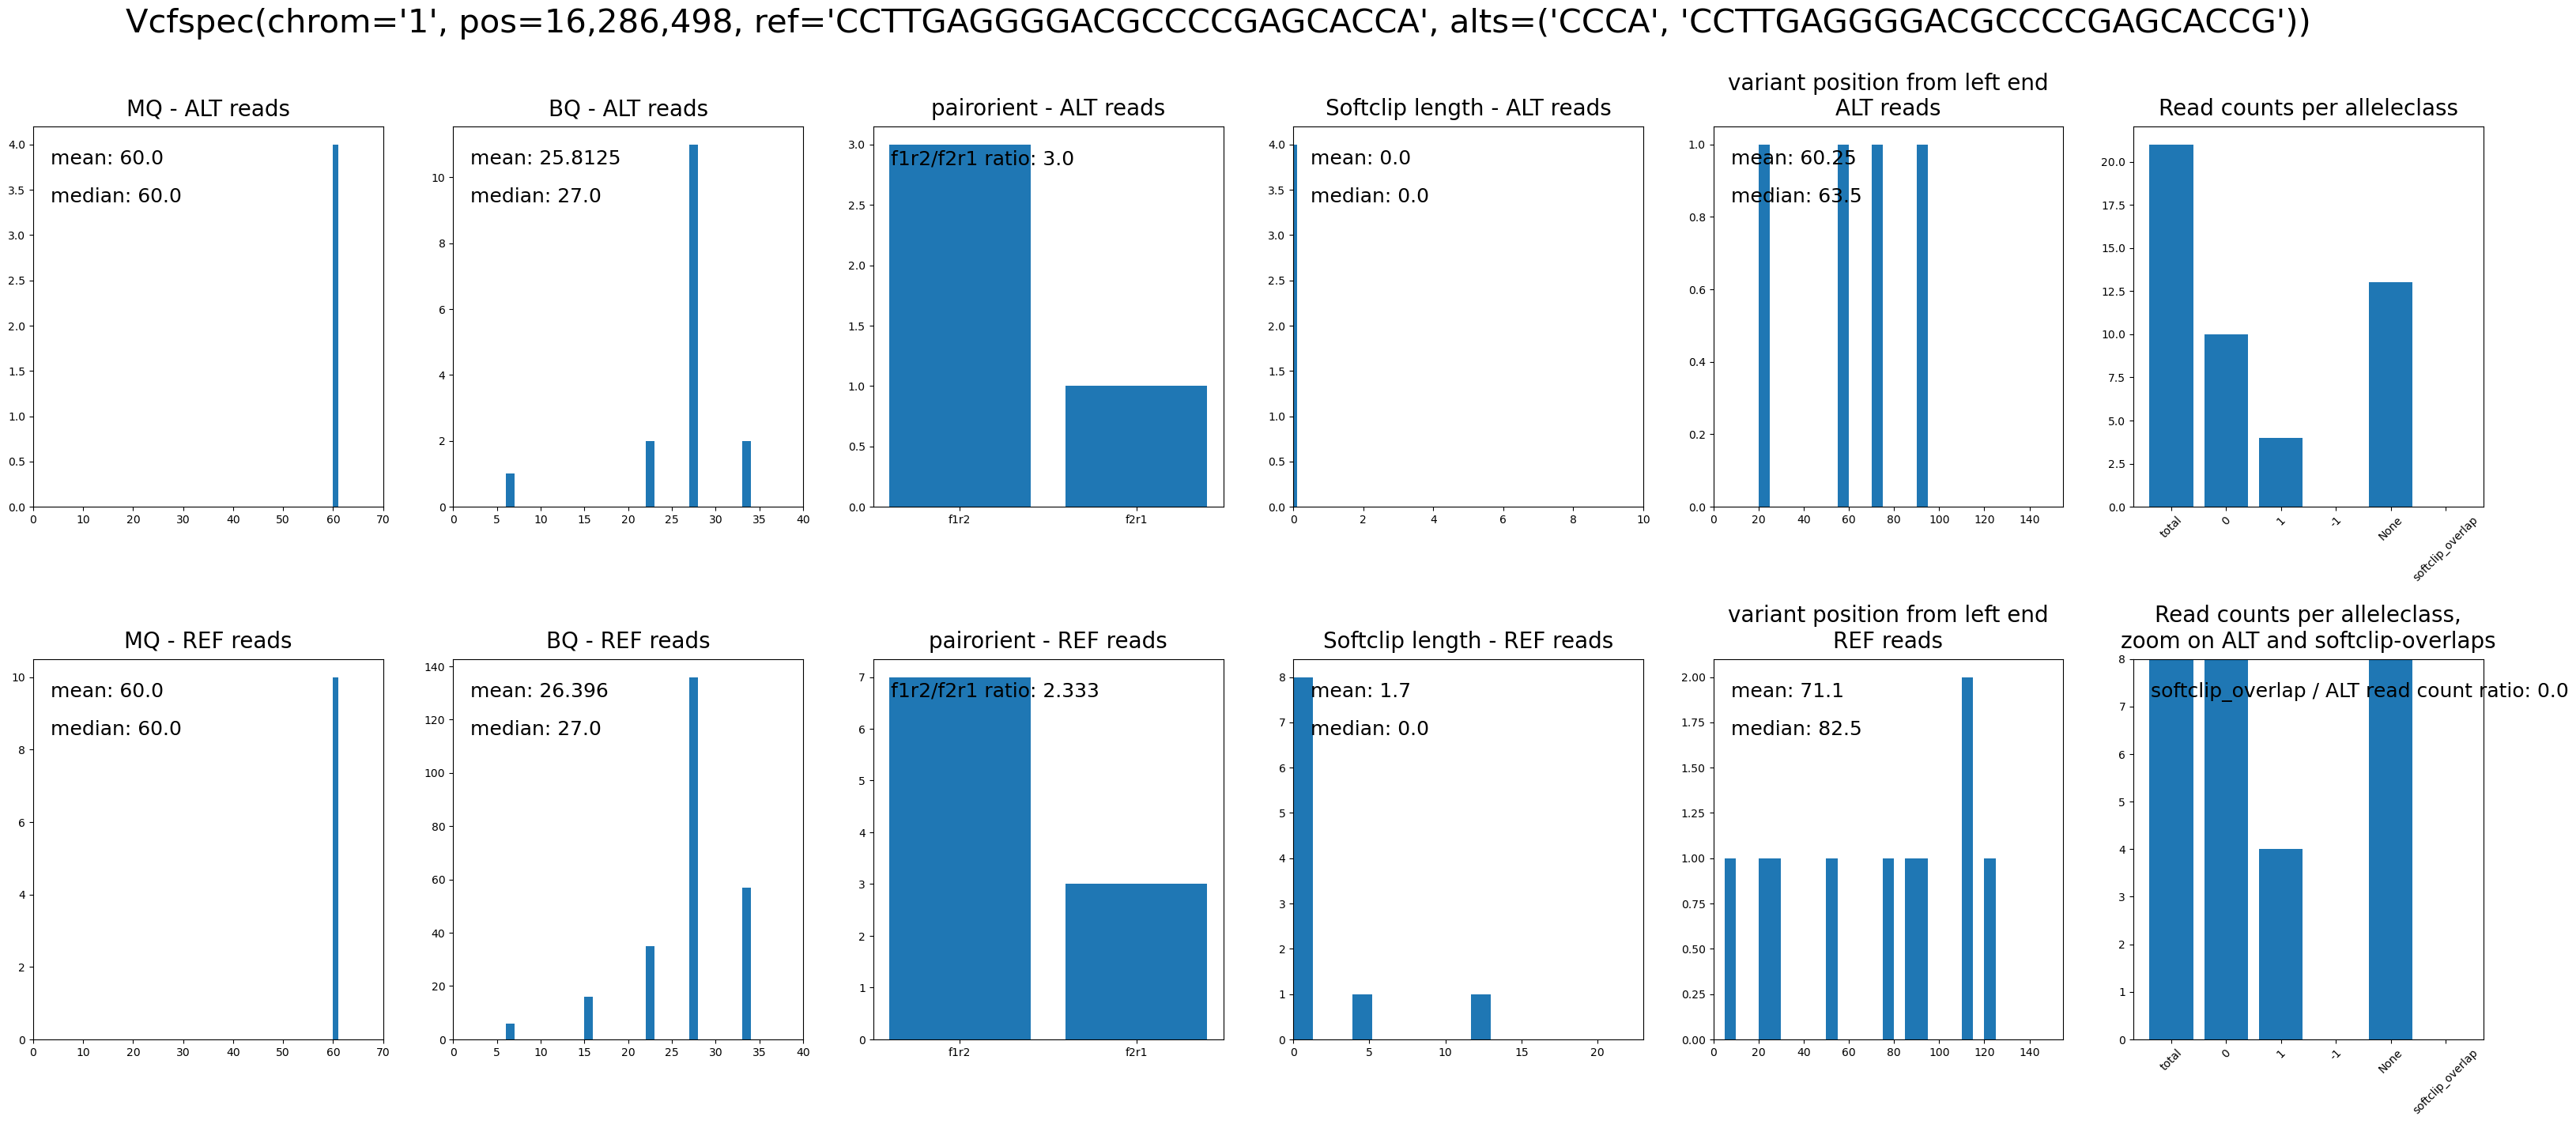

In [85]:
vp.show_readstats_data(bam_dict['tumor'])

In [43]:
vplist = VariantPlusList.from_vcf(REALIGN_RESULT_PATHS['LU-14']['indel']['new'], init_all_attrs=True)

In [46]:
vp = vplist[5]

In [48]:
show_vp_igv(vp, 'LU-14')

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [37]:
result_indel = dict()
for sid in SAMPLEIDS_LU:
    print(sid)
    indel_new_vplist = VariantPlusList.from_vcf(REALIGN_RESULT_PATHS[sid]['indel']['new'], init_all_attrs=True)
    indel_old_vplist = VariantPlusList.from_vcf(REALIGN_RESULT_PATHS[sid]['indel']['old'], init_all_attrs=True)
    # snv_new_vplist = VariantPlusList.from_vcf(REALIGN_RESULT_PATHS[sid]['snv']['new'], init_all_attrs=True)
    # snv_old_vplist = VariantPlusList.from_vcf(REALIGN_RESULT_PATHS[sid]['snv']['old'], init_all_attrs=True)
    
    result_indel[sid] = list()
    for idx, (old_vp, new_vp) in enumerate(zip(indel_old_vplist, indel_new_vplist)):
        if (not check_altering(old_vp)) and check_altering(new_vp):
            print(new_vp)
            result_indel[sid].append([idx, old_vp, new_vp])

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18


[KST 2023-06-15 09:35:14.270] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:35:16.139] VariantPlusList: Processing 1,000th line


LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53


[KST 2023-06-15 09:35:30.750] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:35:31.820] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:35:33.054] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 09:35:34.128] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 09:35:35.197] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 09:35:36.577] VariantPlusList: Processing 6,000th line
[KST 2023-06-15 09:35:37.770] VariantPlusList: Processing 7,000th line
[KST 2023-06-15 09:35:39.834] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:35:41.399] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:35:42.567] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 09:35:43.799] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 09:35:45.026] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 09:35:46.694] VariantPlusList: Processing 6,000th line
[KST 2023-06-15 09:35:48.015] VariantPlusList: Processing 7,000th line


LU-FF56


[KST 2023-06-15 09:35:50.275] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:35:51.863] VariantPlusList: Processing 1,000th line


LU-FF57
LU-FF58
LU-FF6
LU-FF62


[KST 2023-06-15 09:35:56.337] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:35:57.585] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:35:58.550] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 09:35:59.632] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 09:36:00.981] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 09:36:02.115] VariantPlusList: Processing 6,000th line
[KST 2023-06-15 09:36:03.174] VariantPlusList: Processing 7,000th line
[KST 2023-06-15 09:36:04.650] VariantPlusList: Processing 8,000th line
[KST 2023-06-15 09:36:06.571] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:36:07.770] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:36:09.271] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 09:36:10.476] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 09:36:11.648] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 09:36:12.899] VariantPlusList: Processing 6,000th line
[KST 2

LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80


[KST 2023-06-15 09:36:24.222] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:36:25.236] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:36:26.561] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 09:36:28.735] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:36:29.901] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:36:31.522] VariantPlusList: Processing 3,000th line


<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=158,619,728, ref='AATTCAATTCCTAAAAGAG', alts=('CATTCAATTCCTAAAAGA', 'CATTCAATTCCTAAAAGAG')), alteration=(alt_index 0: SPTA1 3478-9_3487delinsTCTTTTAGGAATTGAATG; alt_index 1: SPTA1 S1163A))>
LU-FF85


[KST 2023-06-15 09:36:34.145] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:36:35.584] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:36:37.062] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:36:38.243] VariantPlusList: Processing 2,000th line


LU-IO05


[KST 2023-06-15 09:36:40.146] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:36:41.900] VariantPlusList: Processing 1,000th line


LU-IO06
LU-IO07


[KST 2023-06-15 09:36:45.688] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:36:46.772] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:36:47.779] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 09:36:49.132] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 09:36:50.231] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 09:36:51.331] VariantPlusList: Processing 6,000th line
[KST 2023-06-15 09:36:53.901] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:36:55.156] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:36:56.816] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 09:36:59.258] VariantPlusList: Processing 4,000th line
[KST 2023-06-15 09:37:00.643] VariantPlusList: Processing 5,000th line
[KST 2023-06-15 09:37:01.888] VariantPlusList: Processing 6,000th line


LU-IO08
LU-IO09


[KST 2023-06-15 09:37:05.361] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:06.448] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:37:09.182] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:10.399] VariantPlusList: Processing 2,000th line


LU-IO12


[KST 2023-06-15 09:37:11.852] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:13.189] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:37:15.003] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:16.165] VariantPlusList: Processing 2,000th line


LU-IO13


[KST 2023-06-15 09:37:18.399] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:19.469] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:37:21.582] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:22.784] VariantPlusList: Processing 2,000th line


LU-IO15
LU-IO16


[KST 2023-06-15 09:37:27.998] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:30.173] VariantPlusList: Processing 1,000th line


LU-IO17


[KST 2023-06-15 09:37:31.848] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:32.852] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:37:33.959] VariantPlusList: Processing 3,000th line
[KST 2023-06-15 09:37:36.192] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:37.329] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:37:38.561] VariantPlusList: Processing 3,000th line


LU-IO18
LU-IO22


[KST 2023-06-15 09:37:43.426] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:44.746] VariantPlusList: Processing 2,000th line
[KST 2023-06-15 09:37:46.907] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:48.418] VariantPlusList: Processing 2,000th line


LU-IO23


[KST 2023-06-15 09:37:50.551] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:52.295] VariantPlusList: Processing 1,000th line


LU-IO24
LU-IO25


[KST 2023-06-15 09:37:54.899] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:37:56.273] VariantPlusList: Processing 1,000th line


LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88


[KST 2023-06-15 09:38:05.123] VariantPlusList: Processing 1,000th line
[KST 2023-06-15 09:38:07.399] VariantPlusList: Processing 1,000th line


LU-SC97
LU-SC98


In [38]:
result_indel['LU-FF80']

[[108,
  <VariantPlus(vcfspec=Vcfspec(chrom='1', pos=158,619,745, ref='AG', alts=('A',)), alteration=(alt_index 0: SPTA1 3478-9del))>,
  <VariantPlus(vcfspec=Vcfspec(chrom='1', pos=158,619,728, ref='AATTCAATTCCTAAAAGAG', alts=('CATTCAATTCCTAAAAGA', 'CATTCAATTCCTAAAAGAG')), alteration=(alt_index 0: SPTA1 3478-9_3487delinsTCTTTTAGGAATTGAATG; alt_index 1: SPTA1 S1163A))>]]

In [42]:
show_vp_igv(result_indel['LU-FF80'][0][2], 'LU-FF80')

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [29]:
result_snv = list()
for idx, (old_vp, new_vp) in enumerate(zip(snv_old_vplist, snv_new_vplist)):
    if (not check_altering(old_vp)) and check_altering(new_vp):
        print(new_vp)
        result_snv.append([idx, old_vp, new_vp])

In [543]:
vp = vplist[0]

In [544]:
vp

<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=16,286,498, ref='CCTTGAGGGGACGCCCCGAGCACCA', alts=('CCCA', 'CCTTGAGGGGACGCCCCGAGCACCG')), alteration=(alt_index 0: ; alt_index 1: ))>

In [527]:
vp.create_features()

[KST 2023-06-14 17:33:09] Trying to send http request to http://grch37.rest.ensembl.org/vep/human/hgvs?distance=5000&CADD=1&canonical=1&mane=1&miRNA=0&numbers=1&protein=1&ccds=1&hgvs=1
[KST 2023-06-14 17:33:13] Trying to send http request to http://grch37.rest.ensembl.org/lookup/id/ENST00000375743?expand=0
[KST 2023-06-14 17:33:14] Trying to send http request to http://grch37.rest.ensembl.org/lookup/id/ENST00000537142?expand=0
[KST 2023-06-14 17:33:15] Trying to send http request to http://grch37.rest.ensembl.org/lookup/id/ENST00000375733?expand=0
[KST 2023-06-14 17:33:15] Trying to send http request to http://grch37.rest.ensembl.org/lookup/id/ENST00000448462?expand=0
[KST 2023-06-14 17:33:16] Trying to send http request to http://grch37.rest.ensembl.org/lookup/id/ENST00000479282?expand=0
[KST 2023-06-14 17:33:17] Trying to send http request to http://grch37.rest.ensembl.org/lookup/id/ENST00000375743?expand=0
[KST 2023-06-14 17:33:17] Trying to send http request to http://grch37.rest.e

In [545]:
vp.create_oncokb(ONCOKB_TOKEN)

[KST 2023-06-14 17:40:03] Trying to send http request to https://www.oncokb.org/api/v1/annotate/mutations/byHGVSg


In [546]:
vp.oncokb[1]

<OncoKBInfo(
    {'query': {'id': None,
               'referenceGenome': 'GRCh37',
               'hugoSymbol': None,
               'entrezGeneId': None,
               'alteration': '',
               'alterationType': None,
               'svType': None,
               'tumorType': None,
               'consequence': None,
               'proteinStart': None,
               'proteinEnd': None,
               'hgvs': '1:g.16286522A>G'},
     'geneExist': False,
     'variantExist': None,
     'alleleExist': None,
     'oncogenic': 'Unknown',
     'mutationEffect': {'knownEffect': 'Unknown',
                        'description': '',
                        'citations': {'pmids': [], 'abstracts': []}},
     'highestSensitiveLevel': None,
     'highestResistanceLevel': None,
     'highestDiagnosticImplicationLevel': None,
     'highestPrognosticImplicationLevel': None,
     'highestFdaLevel': None,
     'otherSignificantSensitiveLevels': [],
     'otherSignificantResistanceLevels': []

In [537]:
vp.oncokb[1]

<OncoKBInfo(
    {'query': {'id': None,
               'referenceGenome': 'GRCh37',
               'hugoSymbol': None,
               'entrezGeneId': None,
               'alteration': '',
               'alterationType': None,
               'svType': None,
               'tumorType': None,
               'consequence': None,
               'proteinStart': None,
               'proteinEnd': None,
               'hgvs': '1:g.16286498_16286522delinsCCTTGAGGGGACGCCCCGAGCACCG'},
     'geneExist': False,
     'variantExist': None,
     'alleleExist': None,
     'oncogenic': 'Unknown',
     'mutationEffect': {'knownEffect': 'Unknown',
                        'description': '',
                        'citations': {'pmids': [], 'abstracts': []}},
     'highestSensitiveLevel': None,
     'highestResistanceLevel': None,
     'highestDiagnosticImplicationLevel': None,
     'highestPrognosticImplicationLevel': None,
     'highestFdaLevel': None,
     'otherSignificantSensitiveLevels': [],
     '

In [547]:
vp.oncokb[0]

<OncoKBInfo(
    {'query': {'id': None,
               'referenceGenome': 'GRCh37',
               'hugoSymbol': None,
               'entrezGeneId': None,
               'alteration': '',
               'alterationType': None,
               'svType': None,
               'tumorType': None,
               'consequence': None,
               'proteinStart': None,
               'proteinEnd': None,
               'hgvs': '1:g.16286499_16286519del'},
     'geneExist': False,
     'variantExist': None,
     'alleleExist': None,
     'oncogenic': 'Unknown',
     'mutationEffect': {'knownEffect': 'Unknown',
                        'description': '',
                        'citations': {'pmids': [], 'abstracts': []}},
     'highestSensitiveLevel': None,
     'highestResistanceLevel': None,
     'highestDiagnosticImplicationLevel': None,
     'highestPrognosticImplicationLevel': None,
     'highestFdaLevel': None,
     'otherSignificantSensitiveLevels': [],
     'otherSignificantResistanceLe

In [536]:
vp.oncokb[0]

<OncoKBInfo(
    {'query': {'id': None,
               'referenceGenome': 'GRCh37',
               'hugoSymbol': None,
               'entrezGeneId': None,
               'alteration': '',
               'alterationType': None,
               'svType': None,
               'tumorType': None,
               'consequence': None,
               'proteinStart': None,
               'proteinEnd': None,
               'hgvs': '1:g.16286498_16286522delinsCCCA'},
     'geneExist': False,
     'variantExist': None,
     'alleleExist': None,
     'oncogenic': 'Unknown',
     'mutationEffect': {'knownEffect': 'Unknown',
                        'description': '',
                        'citations': {'pmids': [], 'abstracts': []}},
     'highestSensitiveLevel': None,
     'highestResistanceLevel': None,
     'highestDiagnosticImplicationLevel': None,
     'highestPrognosticImplicationLevel': None,
     'highestFdaLevel': None,
     'otherSignificantSensitiveLevels': [],
     'otherSignificantResis

In [504]:
vplist[1].vcfspec.components

<VcfspecComponents(
    {1: []}
)>

In [516]:
vp.vcfspec

Vcfspec(chrom='1', pos=16,286,498, ref='CCTTGAGGGGACGCCCCGAGCACCA', alts=('CCCA', 'CCTTGAGGGGACGCCCCGAGCACCG'))

In [517]:
list(vp.vcfspec.iter_vepinput_forms())

[Vcfspec(chrom='1', pos=16,286,498, ref='CCTTGAGGGGACGCCCCGAGCA', alts=('C',)),
 Vcfspec(chrom='1', pos=16,286,522, ref='A', alts=('G',))]

In [499]:
list(vp.vcfspec.iter_monoalts())

[Vcfspec(chrom='1', pos=16,286,498, ref='CCTTGAGGGGACGCCCCGAGCACCA', alts=('CCCA',)),
 Vcfspec(chrom='1', pos=16,286,498, ref='CCTTGAGGGGACGCCCCGAGCACCA', alts=('CCTTGAGGGGACGCCCCGAGCACCG',))]

In [514]:
vp.vcfspec.components

<VcfspecComponents(
    {1: [Vcfspec(chrom='1', pos=16,286,498, ref='CCTTGAGGGGACGCCCCGAGCA', alts=('C',))],
     2: [Vcfspec(chrom='1', pos=16,286,522, ref='A', alts=('G',))]}
)>

In [513]:
len(vp.vcfspec.components[2])

1

In [452]:
msrpileup_ser = librealign_msrpileup_series.MultisampleRealignerPileupSeries(
    chrom=old_vp.chrom, 
    start0=old_vp.start0, 
    end0=old_vp.end0,
    bam_dict=bam_dict, 
    refver='hg19',
    inactive_padding=20,
    verbose=False,
    # start0_limit=146_993_520,
    # end0_limit=146_993_620,
    # max_pileup_width=100,

    active_threshold_vaf=0.05,
)

In [455]:
msrpileup_ser.get_result_vcfspecs(portion_cutoff=0.02, verbose=False)

[Vcfspec(chrom='1', pos=70,682,859, ref='GA', alts=('G',))]

In [458]:
msrpileup_ser.df.iloc[0, 0].show_alns()

superseq id: ReadUID(qname='ST-E00130:582:HC7KJALXX:1:1115:30036:24479', flag=99, chrom='1', pos0=70682782)
row_spec: {'seq': 'TTTGTTTTTTGTTTTTTTGAGATGGCGTTTCGCTCTTGTTGCCCAGGCTGG', 'id': ReadUID(qname='ST-E00130:582:HC7KJALXX:1:1115:30036:24479', flag=99, chrom='1', pos0=70682782), 'span_start0': 70682840, 'span_end0': 70682891, 'span_length': 51, 'left_filled': True, 'right_filled': True, 'cliplen': 0}
alignment:
target            0 TTTGTTTTTTGTTTTTTTGAGATGGCGTTTCGCTCTTGTTGCCCAGGCTGG 51
                  0 ||||||||||||||||||||||||||||||||||||||||||||||||||| 51
query             0 TTTGTTTTTTGTTTTTTTGAGATGGCGTTTCGCTCTTGTTGCCCAGGCTGG 51

contig vcfspec:
	None
subseq_hits 43
subseq_hits_portion 0.8431372549019608
mean_MQ 60.0

@@@@@@@@@@@@@@@@@@@@@

superseq id: ReadUID(qname='ST-E00130:582:HC7KJALXX:2:2106:27478:25112', flag=147, chrom='1', pos0=70682773)
row_spec: {'seq': 'TTTGTTTTTTGTTTTTTTGGATGGCGTTTCGCTCTTGTTGCCCAGGCTGG', 'id': ReadUID(qname='ST-E00130:582:HC7KJALXX:2:2106:27478:2511

### debugging

In [119]:
old_vp = PREVIOUS_WGS_REANNOT_VCF_INDEL[sid].sample()

In [120]:
old_vp

<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=216,291,183, ref='TAC', alts=('T',)), alteration=(alt_index 0: ))>

In [121]:
igv.new()
igv.load([BAM_PATHS['normal'][sid], BAM_PATHS['tumor'][sid]])

OK
OK
OK


In [135]:
igv.goto([old_vp.vcfspec])

OK


In [123]:
msrpileup_ser = librealign_msrpileup_series.MultisampleRealignerPileupSeries(
    chrom=old_vp.chrom, 
    start0=old_vp.start0, 
    end0=old_vp.end0,
    bam_dict=bam_dict, 
    refver='hg19',
    inactive_padding=20,
    verbose=False,
    # start0_limit=146_993_520,
    # end0_limit=146_993_620,
    # max_pileup_width=100,
    
    active_threshold_vaf=0.05,
)

In [124]:
vcfspec = msrpileup_ser.get_result_vcfspecs(portion_cutoff=0.1, verbose=False)[0]

In [125]:
vcfspec

Vcfspec(chrom='1', pos=216,291,183, ref='TACACACACAG', alts=('TACACACAG', 'TACACACACAGAT'))

In [127]:
vcfspec.components

<VcfspecComponents(
    {1: [Vcfspec(chrom='1', pos=216,291,183, ref='TAC', alts=('T',))],
     2: [Vcfspec(chrom='1', pos=216,291,193, ref='G', alts=('GAT',))]}
)>

In [126]:
import re

realigned_bams_topdir = '/home/users/pjh/practice/realign'
realigned_bam_paths = {'tumor': os.path.join(realigned_bams_topdir, '230614_drivertest.bam')}
# realigned_bam_paths = {
#     key: os.path.join(
#         realigned_bams_topdir, 
#         re.sub(r'(bam|cram)$', r'realigned.bam', os.path.basename(val))
#     )
#     for key, val in bam_paths.items()
# }

msrpileup_ser.write_realigned_reads(realigned_bam_paths, padding=500)
realigned_bams = {sampleid: pysam.AlignmentFile(bam_path) for sampleid, bam_path in realigned_bam_paths.items()}

vcfspec = msrpileup_ser.get_result_vcfspecs(portion_cutoff=0.1, verbose=False)[0]

vp = VariantPlus.from_vcfspec(vcfspec)
vp.create_readstats(realigned_bams)

vp.show_igv(
    igv, 
    bam_dict=realigned_bams, 
    viewaspairs=False, 
    new=False, 
    colorby_alleleclass=True,
)

igv.cmd('sort POSITION')
igv.cmd('collapse')

OK
OK
OK
OK
OK
OK
OK
OK


# Find candidate variant sites

In [11]:
PANEL_VCF_INDEL_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220707_indel/02_union/panel_indel_union.annot.readstats_again.vcf.gz'

In [12]:
vcfp_indel = VcfPlus(PANEL_VCF_INDEL_PATH, set_annotdb=True, set_readstats=True, logging_lineno=1000)

[KST 2022-07-18 11:33:21 INFO] handygenome.variantplus.vcfplus: 1000 variant records processed
[KST 2022-07-18 11:33:59 INFO] handygenome.variantplus.vcfplus: 2000 variant records processed


In [13]:
fi_popfreq = libvpfilter.PopfreqFilter(cutoff=0.01, popnames=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"))
fi_diffBQ = libvpfilter.DiffMeanBQFilter(cutoff=-5)
fi_BQ = libvpfilter.AbsMeanBQFilter(cutoff=20)
fi_diffMQ = libvpfilter.DiffMeanMQFilter(cutoff=-15)
fi_MQ = libvpfilter.AbsMeanMQFilter(cutoff=40)
fi_clipovlp = libvpfilter.ClipoverlapFilter(cutoff=1)
fi_varposunif = libvpfilter.VarposUniformFilter(cutoff=0.05)
fi_readcount = libvpfilter.ReadcountFilter(cutoff=2)
fi_otherratio = libvpfilter.OthercountRatioFilter(cutoff=1.5)

ponfilter_params = {
    'deviation_cutoff': 5, 
    'subset_num_cutoff': 3, 
    'subset_fraction': 0.5,
    'germline_vaf_cutoff': 0.2,
    'germline_sample_ratio_cutoff': 0.2,
    'mode': 'mean',
}

In [14]:
def allfilter(vp, sampleid):
    fi_pon = vp.get_ponfilter(sampleids=SAMPLEIDS_LU_PANEL, **ponfilter_params)
    mask_all = all([
        fi_pon.check(vp, sampleid),
        fi_popfreq.check(vp),
        fi_diffBQ.check(vp, sampleid),
        fi_BQ.check(vp, sampleid),
        fi_diffMQ.check(vp, sampleid),
        fi_MQ.check(vp, sampleid),
        fi_clipovlp.check(vp, sampleid),
        fi_readcount.check(vp, sampleid),
        (len(vp.vcfspec.ref) >= 4 or
         fi_otherratio.check(vp, sampleid)),
    ])
    
    return mask_all

def cosmicfilter(vp):
    return vp.get_cosmic_total_occur() > 20

def readcountfilter(vp, sampleid):
    return fi_readcount.check(vp, sampleid)

def PONfilter(vp, sampleid):
    return vp.get_ponfilter(SAMPLEIDS_LU_PANEL, **ponfilter_params).check(vp, sampleid)

def functionalfilter(vp):
    return any(
        any(feature['consequence_flags'][key] for key in (
#             'is_3pUTR_involved', 
#             'is_5pUTR_involved', 
            'is_protein_altering',
        ))
        for feature in vp.annotdb.transcript_canon_ovlp.values()
    )

In [18]:
def vpfilter(vp):
    sampleid = 'LU-87_panel'
#     return functionalfilter(vp) and any(readcountfilter(vp, sampleid) for sampleid in SAMPLEIDS_LU_PANEL)
    return cosmicfilter(vp)
#     return (readcountfilter(vp, sampleid) and PONfilter(vp, sampleid))
#     return allfilter(vp, sampleid)


vcfp_indel.filter_vplist(vpfilter)
print(len(vcfp_indel.vplist_filtered))

4


In [19]:
# vp = vcfp_indel.vplist_filtered.sample()
# vplist = vcfp_indel.vplist_filtered.sample(20)
vplist = vcfp_indel.vplist_filtered

In [21]:
idx = -1

In [22]:
idx += 1
print(idx)
vp = vplist[idx]

0


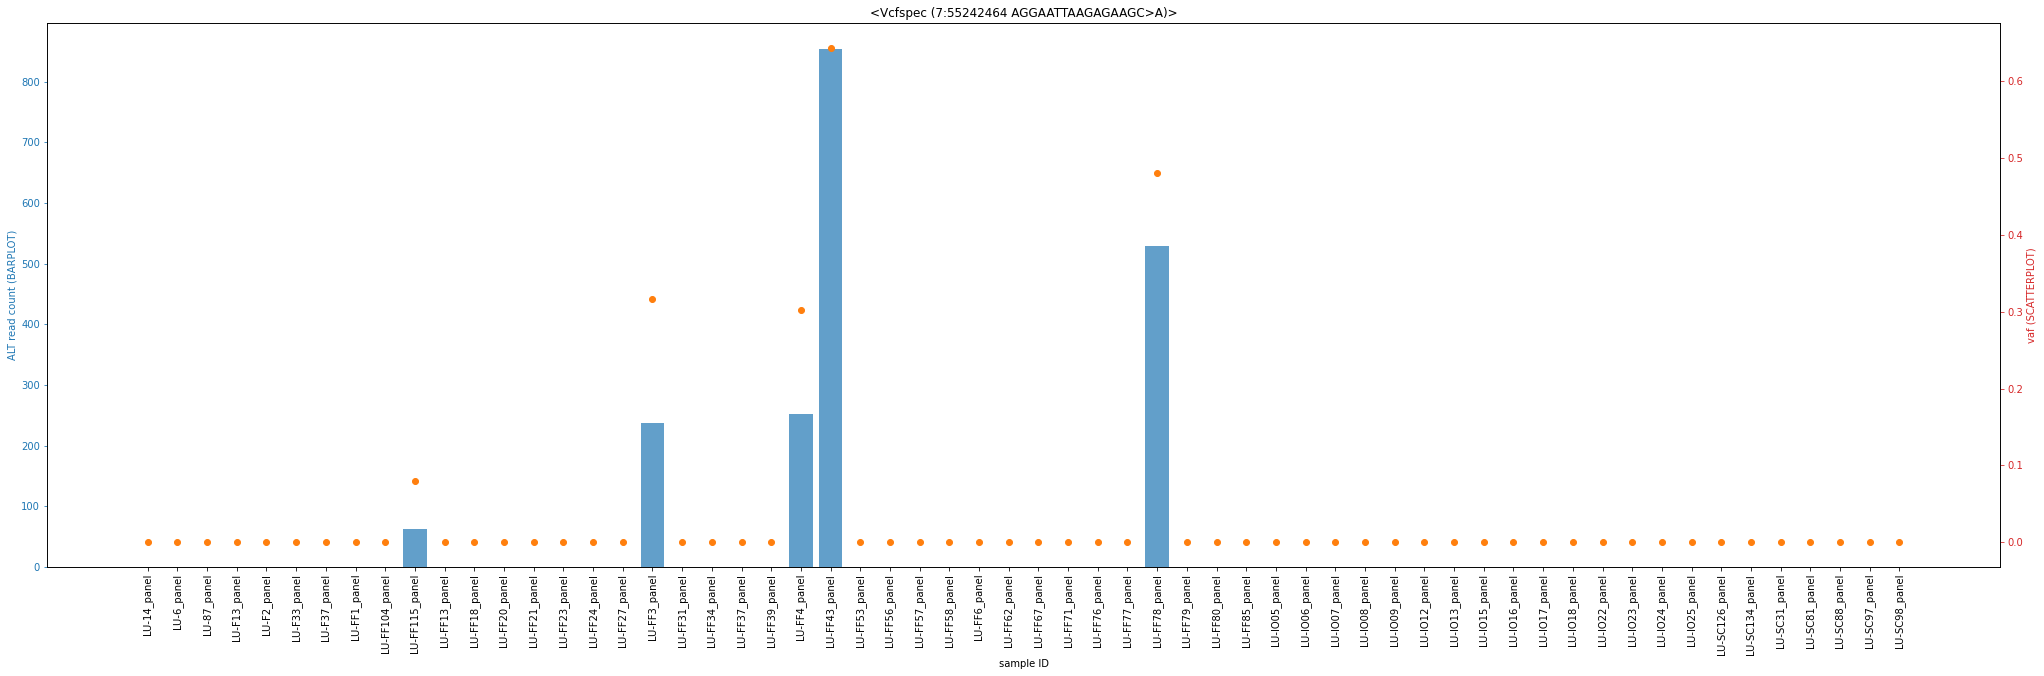

In [24]:
vp.show_readcounts(sampleids=SAMPLEIDS_LU_PANEL, figsize=(35, 10))
# vp.show_readcounts(sampleids=SAMPLEIDS_LU_PANEL, figsize=(35, 10), mask=mask_all)

In [25]:
sampleid = 'LU-FF43'
sampleid_panel = sampleid + '_panel'

In [26]:
show_vp_igv(vp, sampleid)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [ ]:
# Code development

### Basic setups

In [5]:
np.set_printoptions(threshold=np.inf)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

from handygenome.align import realign
from handygenome.align import alignhandler
from handygenome.read import pileup as libpileup
from handygenome.variant import vcfspec as libvcfspec

from handygenome import gatk

realigned_bams_topdir = '/home/users/pjh/practice/realign'

# Main

### Candidate sites

##### Lung cancer panel

In [69]:
vcfspec = Vcfspec ('7', 55_242_466, 'GAA', ('G',), refver='hg19')
sampleid = 'LU-FF56'

locus = (vcfspec.chrom, vcfspec.pos, vcfspec.end0)

In [19]:
vcfspec = Vcfspec ('7', 55_242_464, 'AGGAATTAAGAGAAGC', ('A',), refver='hg19')
sampleid = 'LU-FF43'

locus = (vcfspec.chrom, vcfspec.pos, vcfspec.end0)

In [13]:
vcfspec = Vcfspec('7', 55249017, 'C', ('CCCA',), refver='hg19')
sampleid = 'LU-F33'

locus = (vcfspec.chrom, vcfspec.pos, vcfspec.end0)

In [184]:
vcfspec = Vcfspec('15', 88593724, 'GTGTGTGTGTGTGTGTGTGTGTGTA', ('G',), refver='hg19')
sampleid = 'LU-FF18'

locus = (vcfspec.chrom, vcfspec.pos, vcfspec.end0)

In [399]:
# vcfspec = '[<VariantPlus object (15	88486723	.	GC	G)>]'
vcfspec = Vcfspec('15', 88486723, 'GC', ('G',), refver='hg19')
sampleid = 'LU-FF18'

In [64]:
# vcfspec = '<VariantPlus object (8	32601091	.	CATATATAT	C)>'
vcfspec = Vcfspec('8', 32601091, 'CATATATAT', ('C',), refver='hg19')
sampleid = 'LU-FF20'

In [429]:
# vcfspec = '<VariantPlus object (17	7578503	.	CAGGGCAGGTCT	C)>'
vcfspec = Vcfspec('17', 7578503, 'CAGGGCAGGTCT', ('C',))
sampleid = 'LU-FF20'

In [46]:
# dirty region with heterogeneous softclips AKT1
vcfspec = Vcfspec('14', 105242405, 'CAGCAGGACTCCGCCCCCCCCA', ('C',), refver='hg19')
sampleid = 'LU-FF21'

locus = (vcfspec.chrom, vcfspec.pos, vcfspec.end0)

In [ ]:
# dirty region with heterogeneous softclips CTNNB1
vcfspec = '<VariantPlus object (3	41278937	.	CAAA	C)>'
sampleid = 'LU-IO16'

In [ ]:
# ALT1/ALT2 germline het, with phasable nearby G insertion. The minor(non-germline) allele should be aligned while preserving the major(germline) alleles.
vcfspec = '<VariantPlus object (2	213316731	.	A	AG)>'
sampleid = 'LU-FF3'

In [ ]:
# ALT1/ALT2 germline het
vcfspec = '<VariantPlus object (15	88599429	.	ATATATTTT	A)>'
sampleid = 'LU-FF43'

In [ ]:
# delins reconstruction test
vcfspec = '<VariantPlus object (4	55964315	.	C	CACTT)>'
sampleid = 'LU-FF56'

In [ ]:
# delins reconstruction test
vcfspec = '<VariantPlus object (7	55242466	.	GAA	G)>'
sampleid = 'LU-FF56'

In [ ]:
vcfspec = '<VariantPlus object (2	212488828	.	G	GTC)>'
sampleid = 'LU-FF57'

In [ ]:
# multiple nearby germline variants interspersed with a somatic mutation. For genotype resolution practice.
vcfspec = '<VariantPlus object (2	212488828	.	G	GTC)>'
sampleid = 'LU-FF62_normal, LU-FF62_tumor'

##### MNV examples

In [108]:
vcfspec = Vcfspec(chrom='12', pos=133256222, ref='CC', alts=('TA',), refver='hg19')
sampleid = 'LU-IO09'

locus = (vcfspec.chrom, vcfspec.pos0 + 1, vcfspec.end0)

In [106]:
# LU-FF85 <VariantPlus(chrom=8, pos=32621872, ref=GG, alts=('TT',), gene=alt_index 0: NRG1:p.Gln630_Ala631delinsHisSer)>
sampleid = 'LU-FF85'
locus = ('8', 32621872, 32621872)

In [111]:
# LU-IO15 <VariantPlus(chrom=7, pos=55221785, ref=AT, alts=('GA',), gene=alt_index 0: EGFR:p.Met277Glu)>

sampleid = 'LU-IO15'
locus = ('7', 55221785, 55221785)

In [ ]:
# LU-IO23 <VariantPlus(chrom=7, pos=4169679, ref=GG, alts=('TT',), gene=alt_index 0: SDK1:p.Gly1360Val)>
# LU-SC134 <VariantPlus(chrom=1, pos=11298605, ref=CG, alts=('AC',), gene=alt_index 0: MTOR:p.Arg619Val)>
# LU-IO22 <VariantPlus(chrom=17, pos=7577137, ref=CC, alts=('AG',), gene=alt_index 0: TP53:p.Arg267Pro)>

##### Mutec2 poor cases

In [35]:
# to confirm pairwise2 works well with this pattern
# vcfspec = '15:88408511 CC>CAA'
sampleid = 'LU-FF62'

locus = ('15', 88408510, 88408515)

In [164]:
# check the VAF of deletion to the right
# vcfspec = '<VariantPlus object (2	213316731	.	A	AG)>'
sampleid = 'LU-FF80'

locus = ('2', 213316731, 213316731)

In [20]:
bam_paths = {
    'normal': BAM_PATHS['normal'][sampleid],
    'tumor': BAM_PATHS['tumor'][sampleid],
    #'panel': BAM_PATHS['panel'][sampleid],
}

##### yunah examples

In [40]:
vcf_path = '/home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/03_haplotypecaller/HC08/HC08-03.hc.ft.vcf.gz'
bam_paths = {
    'HC08-00': '/home/users/team_projects/hcolon_heterogeneity/01_LINE1/01_WGS/01_bam/HC08/HC08-00.s.md.bam',
    'HC08-01': '/home/users/team_projects/hcolon_heterogeneity/01_LINE1/01_WGS/01_bam/HC08/HC08-01.s.md.bam',
    
    'HC08-03': '/home/users/team_projects/hcolon_heterogeneity/01_LINE1/01_WGS/01_bam/HC08/HC08-03.s.md.bam',
    # 'HC08-03-RNA': '/home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-03Aligned.sortedByCoord.out.bam',
}
bams = {key: pysam.AlignmentFile(val) for key, val in bam_paths.items()}

locus = ('1', 3_522_119, 3_522_119)

# vcfspec = Vcfspec('1', 7892778, 'AT', ('A',))

[W::hts_idx_load3] The index file is older than the data file: /home/users/team_projects/hcolon_heterogeneity/01_LINE1/01_WGS/01_bam/HC08/HC08-01.s.md.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /home/users/team_projects/hcolon_heterogeneity/01_LINE1/01_WGS/01_bam/HC08/HC08-03.s.md.bam.bai


In [45]:
bam_topdir = '/home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC21/star'
bam_paths = dict()
for fname in os.listdir(bam_topdir):
    if fname.endswith('sortedByCoord.out.bam'):
        sid = fname.split('Aligned')[0]
        bam_paths[sid] = os.path.join(bam_topdir, fname)
bam_paths = {
    k: v for k, v in bam_paths.items() 
    if k.split('-')[1] in ['02', '07', '10', '06', '03', '04', '08', '13']
}


locus = ('X', 54095232, 54095232)

In [97]:
bam_topdir = '/home/users/yunah1029/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star'
bam_paths = dict()
for f in os.listdir(bam_topdir):
    if f.endswith('.sortedByCoord.out.bam'):
        sid = f.split('Aligned')[0]
        bam_paths[sid] = os.path.join(bam_topdir, f)
        
locus = ('X', 10004356, 10004358)

##### anjisong examples

In [5]:
bam_paths = {
    'tumor': '/home/users/anjisong/project/13_VNTR/01_BAM/00_GastricCancer/2_O.splitmark.realigned.recal.bam',
    'normal': '/home/users/anjisong/project/13_VNTR/01_BAM/00_GastricCancer/2_N.splitmark.realigned.recal.bam',
}

locus = ('8', 144_448_678, 144_448_683)

In [74]:
DB3_topdir = '/home/users/team_projects/Lineage_tracing/DB3/02_BAM'
bam_paths = {
    '3_LLL-1_Fb_001C3': os.path.join(DB3_topdir, '3_LLL-1_Fb_001C3.s.md.ir.br.cram'),
    '3_LSM_001B10': os.path.join(DB3_topdir, '3_LSM_001B10.s.md.ir.br.cram'),
}
# bam_dict = {key: pysam.AlignmentFile(val) for key, val in bam_paths.items()}

locus1 = ('17', 3_468_331, 3_468_331)
locus2 = ('18', 3_262_072, 3_262_072)
locus3 = ('18', 3_262_416, 3_262_416)

locus = locus2

In [111]:
DB6_topdir = '/home/users/team_projects/Lineage_tracing/DB6/02_BAM/'
bam_paths = {
    '6_LLLL-24_001F5': os.path.join(DB6_topdir, '6_LLLL-24_001F5.s.md.ir.br.rmBDBI.bam'),
    '6_LOF-2_002E12': os.path.join(DB6_topdir, '6_LOF-2_002E12.s.md.ir.br.rmBDBI.bam'),
    '6_MS-2_001C5' : os.path.join(DB6_topdir, '6_MS-2_001C5.s.md.ir.br.rmBDBI.bam'),
    '6_RCM-1_001C1' : os.path.join(DB6_topdir, '6_RCM-1_001C1.s.md.ir.br.rmBDBI.bam'),
    '6_RDA-4_001D7' : os.path.join(DB6_topdir, '6_RDA-4_001D7.s.md.ir.br.rmBDBI.bam'),
    # '6_REA-4_001F7' : os.path.join(DB6_topdir, '6_REA-4_001F7.s.md.ir.br.rmBDBI.bam'),
    # '6_RUAA-4_001F3' : os.path.join(DB6_topdir, '6_RUAA-4_001F3.s.md.ir.br.rmBDBI.bam'),
    # '6_LMCS-10_001G11' : os.path.join(DB6_topdir, '6_LMCS-10_001G11.s.md.ir.br.rmBDBI.bam'),
    # '6_RtHand-1_001C3' : os.path.join(DB6_topdir, '6_RtHand-1_001C3.s.md.ir.br.rmBDBI.bam'),
    # '6_RUAP-12_001C2' : os.path.join(DB6_topdir, '6_RUAP-12_001C2.s.md.ir.br.rmBDBI.bam'),
}

locus = ('X', 146_993_558, 146_993_642)  

##### jinsil samples

In [26]:
bam_topdir = '/home/users/jinsil/project/01_MUTYH/02_SPS/02_BAM/dna_bam'
bam_paths = {
    x.split('.')[0]: os.path.join(bam_topdir, x)
    for x in os.listdir(bam_topdir) if x.endswith('bam')
}
bam_paths = {key: bam_paths[key] for key in list(bam_paths.keys())[:7]}
    
locus = ('5', 117_185_267, 117185296)
# locus = ('5', 106857174, 106857174)

In [29]:
bam_paths = {
    k: bam_paths[k] 
    for k in list(bam_paths.keys())[:3]
}

### Setup bams and loci

In [98]:
bam_dict = {key: pysam.AlignmentFile(val) for key, val in bam_paths.items()}
chrom, start1, end1 = locus
start0 = start1 - 1
end0 = end1
loci = [locus]

igv.cmd('new')
igv.load(list(bam_paths.values()))
igv.goto(loci, width=30)
igv.cmd('squish')

[W::hts_idx_load3] The index file is older than the data file: /home/users/yunah1029/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-08Aligned.sortedByCoord.out.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /home/users/yunah1029/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-18Aligned.sortedByCoord.out.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /home/users/yunah1029/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-01Aligned.sortedByCoord.out.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /home/users/yunah1029/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-04Aligned.sortedByCoord.out.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /home/users/yunah1029/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-14Aligned.sortedByCoord.out.bam.bai
[W::hts_idx_load3] The index f

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


### Perform realignment - Mutect2

In [38]:
realigned_bam_path = os.path.join(realigned_bams_topdir, 'Mutect2_realign.bam')

vplist = gatk.realign_with_Mutect2(
    bam_path_list=list(bam_paths.values()),
    chrom=chrom, start0=start0, end0=end0,
    fasta_path=FASTA_PATH_HG19,
    realigned_bam_path=realigned_bam_path,
)

[E::idx_find_and_load] Could not retrieve index file for '/home/users/pjh/scripts/python_genome_package_dev/tests/tmpdir_Mutect2_realignment_zamg7a2f/output.vcf.gz'


In [39]:
vplist

<VariantPlusList of length 2 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='15', pos=88,408,511, ref='C', alts=('CA',)), gene=(alt_index 0: ))>
	1	<VariantPlus(vcfspec=Vcfspec(chrom='15', pos=88,408,512, ref='C', alts=('A',)), gene=(alt_index 0: ))>
]

In [35]:
split_bams = gatk.split_realigned_bam(realigned_bam_path)

In [37]:
vp = VariantPlus.from_vcfspec(vplist[0].vcfspec)

print(vp)

vp.create_readstats(
    split_bams,
    rpplist_kwargs={
        'view': False,
        'no_matesearch': True,
        'recalc_NMMD': True,
    },
)
vp.show_igv(
    igv, split_bams,
    new=False,
    rpplist_kwargs={
        'view': True,
        'no_matesearch': True,
        'recalc_NMMD': True,
    },
)

igv.cmd('sort POSITION')
igv.cmd('collapse')

<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=117,185,270, ref='G', alts=('T',)), gene=(alt_index 0: ))>
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [38]:
for sampleid, db in vp.readstats_dict.items():
    print(sampleid, db['rppcounts'])

sps003_NC01-02_DNA {None: 1, -1: 0, 0: 28, 1: 1, 'softclip_overlap': 1}
sps003_SPC01-14_DNA {None: 1, -1: 1, 0: 18, 1: 1, 'softclip_overlap': 0}
sps003_SPC01-15_DNA {None: 0, -1: 0, 0: 18, 1: 2, 'softclip_overlap': 0}
sps003_SPC01-17_DNA {None: 1, -1: 1, 0: 30, 1: 2, 'softclip_overlap': 0}
sps003_SPC01-22_DNA {None: 2, -1: 0, 0: 21, 1: 2, 'softclip_overlap': 1}


In [197]:
import handygenome.variant.vcfspec as libvcfspec

# vcfspec1 = Vcfspec('5', 117_185_296, 'A', ('T',), refver='hg19')
# vcfspec2 = Vcfspec('5', 117_185_303, 'A', ('TGG',), refver='hg19')

vcfspec1 = Vcfspec('5', 117_185_296, 'A', ('T',), refver='hg19')
vcfspec2 = Vcfspec('5', 117_185_296, 'A', ('G',), refver='hg19')

### Perform realignment - handygenome

##### Run realigner function

In [8]:
import handygenome.align.realign as realign
import time

np.seterr(all='raise')

t1 = time.perf_counter()

msrpileup_ser = realign.MultisampleRealignerPileupSeries(
    chrom=chrom, 
    start0=start0, 
    end0=end0,
    bam_dict=bam_dict, 
    refver='hg19',
    inactive_padding=20,
    verbose=False,
    # start0_limit=146_993_520,
    # end0_limit=146_993_620,
    # max_pileup_width=100,
)

t2 = time.perf_counter()
print(t2 - t1)

AttributeError: 'RealignerPileup' object has no attribute 'contig_vcfspecs'

In [110]:
msrpileup_ser.df

,"[55242439, 55242512)"
normal,"<RealignerPileup(chrom=7, start0=55,242,439, e..."
tumor,"<RealignerPileup(chrom=7, start0=55,242,439, e..."


In [111]:
vcfspec = msrpileup_ser.get_result_vcfspecs(portion_cutoff=0.1, verbose=False)[0]

In [112]:
vcfspec

Vcfspec(chrom='7', pos=55,242,464, ref='AGGAATTAAGAGAAGC', alts=('A',))

In [113]:
vcfspec.components

<VcfspecComponents(
    {1: []}
)>

##### Show realigned bam and colorize by alleleclass

In [119]:
import re

realigned_bams_topdir = '/home/users/pjh/practice/realign'
realigned_bam_paths = {
    key: os.path.join(realigned_bams_topdir, re.sub(r'(bam|cram)$', r'realigned.bam', os.path.basename(val)))
    for key, val in bam_paths.items()
}

msrpileup_ser.write_realigned_reads(realigned_bam_paths, padding=500)
realigned_bams = {sampleid: pysam.AlignmentFile(bam_path) for sampleid, bam_path in realigned_bam_paths.items()}

vcfspec = msrpileup_ser.get_result_vcfspecs(portion_cutoff=0.1, verbose=False)[0]

vp = VariantPlus.from_vcfspec(vcfspec)
vp.create_readstats(realigned_bams)

vp.show_igv(igv, bam_dict=realigned_bams, viewaspairs=False, new=True)

igv.cmd('sort POSITION')
igv.cmd('collapse')

ST-E00181:657:HNYC7CCXY:4:1213:32512:50498 False
0.0 1.7000000000000002
-15.0 1.7000000000000002
ST-E00181:657:HNYC7CCXY:2:1214:26250:17008 False
0.0 1.7000000000000002
-15.0 1.7000000000000002
ST-E00181:657:HNYC7CCXY:6:1103:13555:25007 False
0.0 1.7000000000000002
-15.0 1.7000000000000002
ST-E00181:657:HNYC7CCXY:4:2212:17015:72350 False
0.0 1.7000000000000002
-15.0 1.7000000000000002
ST-E00181:657:HNYC7CCXY:7:1212:11677:24005 False
0.0 1.7000000000000002
-15.0 1.7000000000000002
ST-E00181:657:HNYC7CCXY:7:2108:14874:28488 False
0.0 1.7000000000000002
-15.0 1.7000000000000002
ST-E00181:657:HNYC7CCXY:1:2218:30594:43800 False
0.0 1.7000000000000002
-15.0 1.7000000000000002
ST-E00181:657:HNYC7CCXY:3:2107:24779:16463 False
0.0 1.7000000000000002
-15.0 1.7000000000000002
ST-E00181:657:HNYC7CCXY:8:2110:22404:46208 False
0.0 1.7000000000000002
-15.0 1.7000000000000002
ST-E00181:657:HNYC7CCXY:8:1108:10713:70539 False
0.0 1.7000000000000002
-15.0 1.7000000000000002
ST-E00181:657:HNYC7CCXY:5:1207

In [128]:
igv.cmd('viewaspairs')

OK


In [120]:
igv.snapshot('/home/users/pjh/tmp/snapshot.png', maxPanelHeight=10000)

OK
OK
OK


In [96]:
vp = VariantPlus.from_vcfspec(vcfspec)
vp.create_oncokb(ONCOKB_TOKEN)
print(vp.oncokb)

<OncoKBInfoALTlist(
    [<OncoKBInfo(
        {'query': {'id': None,
                   'referenceGenome': 'GRCh37',
                   'hugoSymbol': 'EGFR',
                   'entrezGeneId': 1956,
                   'alteration': 'E746_T751delinsVA',
                   'alterationType': None,
                   'svType': None,
                   'tumorType': None,
                   'consequence': 'inframe_deletion',
                   'proteinStart': 746,
                   'proteinEnd': 751,
                   'hgvs': '7:g.55242466_55242483delinsGTTGCT'},
         'geneExist': True,
         'variantExist': True,
         'alleleExist': False,
         'oncogenic': 'Oncogenic',
         'mutationEffect': {'knownEffect': 'Gain-of-function',
                            'description': 'The EGFR exon 19 E746_T751delinsVA '
                                           'mutation occurs in the EGFR tyrosine '
                                           'kinase domain. In-frame deletions of E

##### Vcfspec object

In [81]:
vcfspec.components

<VcfspecComponents(
    {0: [Vcfspec(chrom='X', pos=54,095,222, ref='CAGAAT', alts=('C',)),
         Vcfspec(chrom='X', pos=54,095,232, ref='T', alts=('C',)),
         Vcfspec(chrom='X', pos=54,095,242, ref='T', alts=('C',))],
     1: [Vcfspec(chrom='X', pos=54,095,227, ref='T', alts=('C',)),
         Vcfspec(chrom='X', pos=54,095,237, ref='T', alts=('C',))]}
)>

In [83]:
vcfspec.get_flank_range0s_equivalents()

(range(54095220, 54095221), range(54095242, 54095282))

In [93]:
for sampleid in vp.readstats_dict.keys():
    print(sampleid)
    vp.show_vafs(sampleid, exclude_other=True)
    print()

HC21-07
CAGAATAGAATAGAATAGAAT 0.0
CAGAACAGAATAGAAC 0.0
CAGAACAGAATAGAACAGAAT 1.0

HC21-10
CAGAATAGAATAGAATAGAAT 0.0
CAGAACAGAATAGAAC 0.0
CAGAACAGAATAGAACAGAAT 1.0

HC21-04
CAGAATAGAATAGAATAGAAT 0.0
CAGAACAGAATAGAAC 1.0
CAGAACAGAATAGAACAGAAT 0.0

HC21-02
CAGAATAGAATAGAATAGAAT 0.0
CAGAACAGAATAGAAC 0.0
CAGAACAGAATAGAACAGAAT 1.0

HC21-03
CAGAATAGAATAGAATAGAAT 0.0
CAGAACAGAATAGAAC 1.0
CAGAACAGAATAGAACAGAAT 0.0

HC21-06
CAGAATAGAATAGAATAGAAT 0.0
CAGAACAGAATAGAAC 0.0
CAGAACAGAATAGAACAGAAT 1.0

HC21-08
CAGAATAGAATAGAATAGAAT 0.0
CAGAACAGAATAGAAC 1.0
CAGAACAGAATAGAACAGAAT 0.0

HC21-13
CAGAATAGAATAGAATAGAAT 0.0
CAGAACAGAATAGAAC 1.0
CAGAACAGAATAGAACAGAAT 0.0



##### Determine genotypes

In [164]:
import handygenome.annotation.genotype as libgenotype

# sampleinfo = {sampleid: {'type': 'clonal'} for sampleid in vp.readstats_dict.keys()}
sampleinfo = {'normal': {'type': 'blood'}, 'tumor': {'type': 'tumor'}}
gtinfo = libgenotype.GenotypeInfo.from_vp(vp, sampleinfo)

In [165]:
gtinfo

<GenotypeInfo(
    {'germline_allele_indexes': [0, 1], 'somatic_allele_indexes': []}
)>

In [28]:
vcfspec.components

<VcfspecComponents(
    {0: [Vcfspec(chrom='5', pos=117,185,270, ref='G', alts=('T',)),
         Vcfspec(chrom='5', pos=117,185,289, ref='AC', alts=('A',))],
     1: [Vcfspec(chrom='5', pos=117,185,272, ref='CA', alts=('C',))],
     2: [Vcfspec(chrom='5', pos=117,185,288, ref='AAC', alts=('A',))],
     3: [Vcfspec(chrom='5', pos=117,185,289, ref='AC', alts=('A',))]}
)>

In [56]:
new_vcfspec = vcfspec.extend_right(1)

ref = new_vcfspec.ref
germline1 = new_vcfspec.alts[1]
germline2 = new_vcfspec.alts[3]
somatic = new_vcfspec.alts[2]

In [6]:
ref = 'GACAAAAAAAAAAAAAAAAACC'
germline1 = 'GACAAAAAAAAAAAAAAAACC'
germline2 = 'GACAAAAAAAAAAAAAAAAAC'
somatic = 'GACAAAAAAAAAAAAAAAAC'

In [7]:
ref

'GACAAAAAAAAAAAAAAAAACC'

In [8]:
germline1

'GACAAAAAAAAAAAAAAAACC'

In [9]:
germline2

'GACAAAAAAAAAAAAAAAAAC'

In [10]:
somatic

'GACAAAAAAAAAAAAAAAAC'

In [15]:
from handygenome.align.realign import ALIGNER_BLASTN
from handygenome.align.realign import ALIGNER_EQUAL_MM_GAP
from handygenome.variant.vcfspec import ALIGNER_DIFF

aligner = ALIGNER_DIFF

alns = aligner.align(germline1, somatic)
for aln in alns:
    print(aln)

target            0 GACAAAAAAAAAAAAAAAACC 21
                  0 |||||||||||||||||||-| 21
query             0 GACAAAAAAAAAAAAAAAA-C 20

target            0 GACAAAAAAAAAAAAAAAACC 21
                  0 ||||||||||||||||||||- 21
query             0 GACAAAAAAAAAAAAAAAAC- 20



In [13]:
print(alns[1])
print(alns[1].path)

target            0 GACAAAAAAAAAAAAAAAACC 21
                  0 ||||||||||||||||||||- 21
query             0 GACAAAAAAAAAAAAAAAAC- 20

((0, 0), (20, 20), (21, 20))


/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/Bio/Align/__init__.py:1269: BiopythonDeprecationWarning: The path attribute is deprecated; please use the coordinates attribute instead. The coordinates attribute is a numpy array containing the same values as the path attributes, after transposition.
  warnings.warn(


In [18]:
aln = alns[1]

In [29]:
print(aln)

target            0 GACAAAAAAAAAAAAAAAACC 21
                  0 ||||||||||||||||||||- 21
query             0 GACAAAAAAAAAAAAAAAAC- 20



In [31]:
aln.coordinates

array([[ 0, 20, 21],
       [ 0, 20, 20]])

### Debugger

In [67]:
old_vp

<VariantPlus(vcfspec=Vcfspec(chrom='8', pos=110,065,060, ref='AGCATGTTATAAAATTG', alts=('A',)), alteration=(alt_index 0: ))>

In [84]:
rpup = librealign_rpileup.RealignerPileup(
    chrom=old_vp.chrom, 
    start0=old_vp.start0, 
    end0=old_vp.end0,
    bam=tbam,
    refver='hg19',
    inactive_padding=20,
    verbose=False,
)

In [90]:
FASTA_HG19

In [92]:
pos0 = 110065059
ref_base = FASTA_HG19.fetch(old_vp.chrom, old_vp.start0, old_vp.start0 + 1)
cnt = rpup.get_allele_counter(pos0)
ref_depth = cnt[ref_base]
depth = sum(cnt.values())

vaf = 1 - (ref_depth / depth)
print(vaf)


0.07894736842105265


In [86]:
rpup.active_info

110065059    True
110065060    True
110065061    True
110065062    True
110065063    True
110065064    True
110065065    True
110065066    True
110065067    True
110065068    True
110065069    True
110065070    True
110065071    True
110065072    True
110065073    True
110065074    True
110065075    True
dtype: bool

In [118]:
import handygenome.align.realign as librealign

msrpileup_ser = realign.MultisampleRealignerPileupSeries(
    chrom=chrom, 
    start0=start0, 
    end0=end0,
    bam_dict=bam_dict, 
    refver='hg19',
    inactive_padding=20,
    verbose=False,
    init_blank=True,
    active_threshold_vaf=0.2,
    active_threshold_depth=8,
)

In [119]:
msrpileup_ser.params

{'inactive_padding': 20,
 'active_threshold_vaf': 0.2,
 'active_threshold_depth': 8,
 'allele_portion_threshold': 0.05,
 'concat_dist_le': None,
 'extend_pileup_by': 20,
 'vcfspec_range_factor': 1.5,
 'start0_limit': -inf,
 'end0_limit': inf,
 'MQ_limit': 20,
 'depth_limit': 1,
 'max_pileup_width': 100,
 'max_series_width': 5000}

In [ ]:
# set_series_dict

msrpileup_ser.pileupseries_dict = dict()
msrpileup_ser.no_variant = False

# initialize
for sampleid, bam in msrpileup_ser.bam_dict.items():
    # self.logger.debug(f'@@@ Initializing RealignerPileupSeries of sample {sampleid} @@@\n')
    msrpileup_ser.pileupseries_dict[sampleid] = librealign.RealignerPileupSeries(
        bam=bam, 
        chrom=msrpileup_ser.chrom, start0=start0, end0=end0, 
        refver=msrpileup_ser.refver,
        fasta=msrpileup_ser.fasta, 
        verbose=msrpileup_ser.verbose,
        logger=msrpileup_ser.logger,
        **msrpileup_ser.params,
    )
    # self.logger.debug(f'@@@ Finished initialization of RealignerPileupSeries of sample {sampleid} @@@\n\n')

# equalize whole margins
msrpileup_ser.equalize_left()
msrpileup_ser.equalize_right()

# equalize sub-pileup margins
# self.logger.debug(f'@@@ Beginning inner margin equalization @@@\n')
# msrpileup_ser.equalize_inner_margins()
# self.logger.debug(f'@@@ Finished inner margin equalization @@@\n')

HC08-08
10004438    False
10004439    False
10004440    False
10004441    False
10004442    False
10004443    False
10004444    False
10004445    False
10004446    False
10004447    False
dtype: bool

HC08-18
10004427    False
10004428    False
10004429    False
10004430    False
10004431    False
10004432    False
10004433    False
10004434    False
10004435    False
10004436    False
10004437    False
10004438    False
10004439    False
10004440    False
10004441    False
10004442    False
10004443    False
10004444    False
10004445    False
10004446    False
10004447    False
dtype: bool

HC08-01
10004438    False
10004439    False
10004440    False
10004441    False
10004442    False
10004443    False
10004444    False
10004445    False
10004446    False
10004447    False
dtype: bool

HC08-04
10004438    False
10004439    False
10004440    False
10004441    False
10004442    False
10004443    False
10004444    False
10004445    False
10004446    False
10004447    False
dtype: bool

KeyboardInterrupt: 

In [117]:
msrpileup_ser

{'HC08-08': <RealignerPileupSeries(pileup_list: [
	0 <RealignerPileup(chrom=X, start0=10,004,224, end0=10,004,228, shape=(0, 4))>
	1 <RealignerPileup(chrom=X, start0=10,004,228, end0=10,004,244, shape=(0, 16))>
	2 <RealignerPileup(chrom=X, start0=10,004,244, end0=10,004,246, shape=(0, 2))>
	3 <RealignerPileup(chrom=X, start0=10,004,246, end0=10,004,264, shape=(0, 18))>
	4 <RealignerPileup(chrom=X, start0=10,004,264, end0=10,004,279, shape=(0, 15))>
	5 <RealignerPileup(chrom=X, start0=10,004,279, end0=10,004,299, shape=(0, 20))>
	6 <RealignerPileup(chrom=X, start0=10,004,299, end0=10,004,315, shape=(0, 16))>
	7 <RealignerPileup(chrom=X, start0=10,004,315, end0=10,004,335, shape=(0, 20))>
	8 <RealignerPileup(chrom=X, start0=10,004,335, end0=10,004,355, shape=(0, 20))>
	9 <RealignerPileup(chrom=X, start0=10,004,355, end0=10,004,358, shape=(0, 3))>
	10 <RealignerPileup(chrom=X, start0=10,004,358, end0=10,004,378, shape=(0, 20))>
	11 <RealignerPileup(chrom=X, start0=10,004,378, end0=10,004,